# Indigenous Territories Land Cover Analysis
## MapBiomas Collection 9 + SPOT Data Analysis in Google Earth Engine

This notebook provides comprehensive land cover change analysis for Brazilian indigenous territories using:
- **MapBiomas Brazil Collection 9** (1985-2023)
- **SPOT 2008 Classification** (Brazil Forest Code project)
- **Official Indigenous Territories Collection**

### 🔧 **Source Information:**
- **Original JavaScript modules location**: `users/leandromet/spot_car/python_mapbiomas/gee_code_editor`
- **Converted to Python**: All functions are now implemented directly in this notebook
- **No external dependencies**: Everything you need is in this notebook

### Key Features:
- Territory-specific filtering to avoid computation timeouts
- Multi-temporal analysis with SPOT baseline validation
- Interactive visualizations with geemap
- Performance-optimized for large-scale analysis

### Default Analysis:
Focuses on Maranhão territories (Bacurizinho, Porquinhos, Kanela Cana Brava/Guajajara) for 1985-2008 period.

### 📝 **Note on JavaScript Modules:**
The original Earth Engine Code Editor uses these modules:
- `config` - Configuration constants and palettes
- `dataLoader` - Data loading functions
- `analysis` - Analysis functions
- `visualization` - Visualization utilities

All these have been converted and included as Python functions in this notebook, so no external module loading is required!

## Table of Contents

- [1. Setup and Authentication](#1.-Setup-and-Authentication)
- [2. Configuration and Constants](#2.-Configuration-and-Constants)
- [3. Data Loading Functions](#3.-Data-Loading-Functions)
- [4. Analysis Functions](#4.-Analysis-Functions)
- [5. Visualization Functions](#5.-Visualization-Functions)
- [6. Main Analysis - Specific Territories with SPOT Data (1985-2008)](#6.-Main-Analysis---Specific-Territories-with-SPOT-Data-(1985-2008))
- [7. Create Interactive Map](#7.-Create-Interactive-Map)
- [8. Calculate Area Statistics](#8.-Calculate-Area-Statistics)
- [9. Visualize Change Analysis](#9.-Visualize-Change-Analysis)
- [10. Display Legend](#10.-Display-Legend)
- [11. Alternative Analysis Options](#11.-Alternative-Analysis-Options)
- [12. Export Results (Optional)](#12.-Export-Results-(Optional))
- [Summary](#Summary)
- [Task: Generate a Sankey diagram showing the land cover transitions](#Task:-Generate-a-Sankey-diagram-showing-the-land-cover-transitions)
    - [Subtask: Obtain land cover transition data (alternative method)](#Subtask:-Obtain-land-cover-transition-data-(alternative-method))
    - [Subtask: Generate a Sankey diagram (Including Persistence)](#Subtask:-Generate-a-Sankey-diagram-(Including-Persistence))
    - [Subtask: Prepare Data and Generate Sankey Diagram](#Subtask:-Prepare-Data-and-Generate-Sankey-Diagram)
- [Task: Generate a multi-node Sankey diagram](#Task:-Generate-a-multi-node-Sankey-diagram)
    - [Subtask: Define time windows](#Subtask:-Define-time-windows)
    - [Subtask: Calculate transitions for each window](#Subtask:-Calculate-transitions-for-each-window)
- [Task: Analyze and compare the land cover changes between indigenous territories and a 10km buffer](#Task:-Analyze-and-compare-the-land-cover-changes-between-indigenous-territories-and-a-10km-buffer)
    - [Subtask: Define buffer geometry](#Subtask:-Define-buffer-geometry)
    - [Subtask: Perform analysis on buffer](#Subtask:-Perform-analysis-on-buffer)
    - [Subtask: Compare area statistics](#Subtask:-Compare-area-statistics)
    - [Subtask: Visualize comparison](#Subtask:-Visualize-comparison)
    - [Subtask: Analyze change within buffer](#Subtask:-Analyze-change-within-buffer)
    - [Subtask: Visualize change comparison](#Subtask:-Visualize-change-comparison)
    - [Subtask: Create map with buffer](#Subtask:-Create-map-with-buffer)
    - [Subtask: Summarize findings](#Subtask:-Summarize-findings)
    - [Subtask: Sankey Diagram for Buffered Area (Including Persistence)](#Subtask:-Sankey-Diagram-for-Buffered-Area-(Including-Persistence))
    - [Subtask: Sankey Diagram for Buffered Area (Changes Only)](#Subtask:-Sankey-Diagram-for-Buffered-Area-(Changes-Only))
    - [Subtask: Multi-node Sankey Diagram for Buffered Area](#Subtask:-Multi-node-Sankey-Diagram-for-Buffered-Area)

## 1. Setup and Authentication

In [ ]:
# Install required packages (run once)
!pip install geemap earthengine-api --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.2 MB/s eta 0:00:00


In [4]:
# Import libraries
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Authenticate and initialize Earth Engine
# For first time users, this will open a browser window for authentication
try:
    # Replace "your-earthengine-project-id" with your actual Earth Engine project ID
    ee.Initialize(project="ee-leandromet")
    print("✅ Earth Engine initialized successfully!")
except Exception as e:
    print(f"🔐 Authentication or initialization failed: {e}")
    print("Attempting authentication...")
    ee.Authenticate()
    # After authentication, re-initialize with the project ID
    ee.Initialize(project="ee-leandromet")
    print("✅ Earth Engine authenticated and initialized!")

🔐 Authentication or initialization failed: Please authorize access to your Earth Engine account by running

earthengine authenticate

in your command line, or ee.Authenticate() in Python, and then retry.
Attempting authentication...
✅ Earth Engine authenticated and initialized!


### 📚 About the Original JavaScript Modules

If you want to use the original JavaScript modules from the Earth Engine Code Editor, they are located at:
```
users/leandromet/spot_car/python_mapbiomas/gee_code_editor/
├── config          # Configuration constants
├── dataLoader      # Data loading functions  
├── analysis        # Analysis functions
└── visualization   # Visualization utilities
```

However, **JavaScript modules cannot be directly imported in Python**. This notebook has converted all the necessary functionality to Python, so you don't need to access the original modules.

If you need to reference the original JavaScript code, you can view it in the Earth Engine Code Editor or in your local repository.

## 2. Configuration and Constants

In [ ]:
# MapBiomas Collections
COLLECTIONS = {
    'v9': 'projects/mapbiomas-public/assets/brazil/lulc/collection9/mapbiomas_collection90_integration_v1',
    'v8': 'projects/mapbiomas-public/assets/brazil/lulc/collection8/mapbiomas_collection80_integration_v1'
}

# Territory Collections
TERRITORY_COLLECTIONS = {
    'indigenous': 'projects/mapbiomas-territories/assets/TERRITORIES-OLD/LULC/BRAZIL/COLLECTION9/WORKSPACE/INDIGENOUS_TERRITORIES',
    'biomes': 'projects/mapbiomas-territories/assets/TERRITORIES-OLD/LULC/BRAZIL/COLLECTION9/WORKSPACE/BIOMES'
}

# SPOT Data (Brazil Forest Code)
SPOT_COLLECTION = 'projects/google/brazil_forest_code/spot_bfc_ms_mosaic_v02'

# Complete Color palette for MapBiomas Collection 9 land cover classes
COLOR_MAP = {
    0: "#ffffff", 1: "#1f8d49", 2: "#1f8d49", 3: "#1f8d49", 4: "#7dc975", 5: "#04381d", 6: "#007785",
    7: "#005544", 8: "#33a02c", 9: "#7a5900", 10: "#d6bc74", 11: "#519799", 12: "#d6bc74", 13: "#ffffff",
    14: "#ffefc3", 15: "#edde8e", 16: "#e974ed", 17: "#d082de", 18: "#e974ed", 19: "#c27ba0", 20: "#db7093",
    21: "#ffefc3", 22: "#d4271e", 23: "#ffa07a", 24: "#d4271e", 25: "#db4d4f", 26: "#2532e4", 27: "#ffffff",
    28: "#ffaa5f", 29: "#ffaa5f", 30: "#9c0027", 31: "#091077", 32: "#fc8114", 33: "#259fe4", 34: "#259fe4",
    35: "#9065d0", 36: "#d082de", 37: "#d082de", 38: "#c27ba0", 39: "#f5b3c8", 40: "#c71585", 41: "#f54ca9",
    42: "#f54ca9", 43: "#d082de", 44: "#d082de", 45: "#d68fe2", 46: "#d68fe2", 47: "#9932cc", 48: "#e6ccff",
    49: "#02d659", 50: "#ad5100", 51: "#fc8114", 52: "#fc8114", 62: "#ff69b4", 146: "#ffefc3", 435: "#cccccc",
    466: "#999999"
}

# Complete Labels for MapBiomas Collection 9 land cover classes
LABELS = {
    0: "No data",
    1: "Forest", 2: "Natural Forest", 3: "Forest Formation", 4: "Savanna Formation", 5: "Mangrove",
    6: "Floodable Forest", 7: "Flooded Forest", 8: "Wooded Restinga", 9: "Forest Plantation",
    10: "Herbaceous", 11: "Wetland", 12: "Grassland", 13: "Other Natural Formation", 14: "Farming",
    15: "Pasture", 16: "Agriculture", 17: "Perennial Crop", 18: "Agri", 19: "Temporary Crop",
    20: "Sugar Cane", 21: "Mosaic of Uses", 22: "Non vegetated", 23: "Beach and Sand", 24: "Urban Area",
    25: "Other non Vegetated Areas", 26: "Water", 27: "Not Observed", 28: "Rocky Outcrop", 29: "Rocky Outcrop",
    30: "Mining", 31: "Aquaculture", 32: "Hypersaline Tidal Flat", 33: "River Lake and Ocean", 34: "Reservoir",
    35: "Palm Oil", 36: "Perennial Crop", 37: "Semi-Perennial Crop", 38: "Annual Crop", 39: "Soybean",
    40: "Rice", 41: "Other Temporary Crops", 42: "Other Annual Crop", 43: "Other Semi-Perennial Crop",
    44: "Other Perennial Crop", 45: "Coffee", 46: "Coffee", 47: "Citrus", 48: "Other Perennial Crops",
    49: "Wooded Sandbank Vegetation", 50: "Herbaceous Sandbank Vegetation", 51: "Salt Flat",
    52: "Apicuns and Salines", 62: "Cotton", 146: "Other Land Use", 435: "Other Transition",
    466: "Other Classification"
}

# Create palette list for visualization
PALETTE = [COLOR_MAP[k] for k in sorted(COLOR_MAP.keys())]

print("✅ Complete configuration loaded successfully!")

✅ Complete configuration loaded successfully!


## 3. Data Loading Functions

In [ ]:
def load_mapbiomas(version='v9'):
    """
    Load MapBiomas Brazil Collection

    Args:
        version: Collection version ('v9' or 'v8')

    Returns:
        ee.Image: MapBiomas image collection
    """
    mapbiomas = ee.Image(COLLECTIONS[version])
    print(f"📊 Loaded MapBiomas Collection {version}")
    return mapbiomas

def load_indigenous_territories():
    """
    Load official MapBiomas Indigenous Territories

    Returns:
        ee.FeatureCollection: Indigenous territories feature collection
    """
    territories = ee.FeatureCollection(TERRITORY_COLLECTIONS['indigenous'])
    count = territories.size().getInfo()
    print(f"🏛️ Loaded {count} indigenous territories")
    return territories

def load_spot_data():
    """
    Load SPOT 2008 multispectral data and create a classification using a Random Forest classifier.

    Returns:
        tuple: (ee.Image: original SPOT image, ee.Image: SPOT classification image)
               Returns (None, ee.Image.constant(0).rename('spot_classification')) if loading or classification fails.
    """
    spot_asset = 'projects/google/brazil_forest_code/spot_bfc_ms_mosaic_v02'
    samples_asset = 'projects/mapbiomas-workspace/SPOT_2008/trainedSamples_2008_level1_SPOT_v2'
    spot_classification = ee.Image.constant(0).rename('spot_classification') # Default placeholder classification
    original_spot_image = None # Placeholder for original image

    try:
        original_spot_image = ee.Image(spot_asset)

        # Check if required bands exist for classification
        band_names = original_spot_image.bandNames().getInfo()
        required_bands = ['N', 'R', 'G']
        if all(band in band_names for band in required_bands):
            # Select bands for classification
            spot_image_for_classification = original_spot_image.select(required_bands)

            # Load training samples
            samples_level1 = ee.FeatureCollection(samples_asset)
            print('📦 Loaded training samples from:', samples_level1.size().getInfo())

            # Define and train the classifier
            classifier = ee.Classifier.smileRandomForest({
                'numberOfTrees': 10
            })

            try:
                spot_image = ee.Image(spot_asset)

                # Create a simple classification based on NDVI
                # Ensure bands 'N' and 'R' exist before calculating NDVI
                band_names = spot_image.bandNames().getInfo()
                if 'N' in band_names and 'R' in band_names:
                    ndvi = spot_image.normalizedDifference(['N', 'R']).rename('ndvi')

                    spot_classification = ee.Image(0) # Start with a default class (e.g., No data)
                    spot_classification = spot_classification.where(ndvi.gt(0.5), 3)  # Forest (using MapBiomas class ID)
                    spot_classification = spot_classification.where(ndvi.lt(0.2), 24) # Urban Area (using MapBiomas class ID)
                    spot_classification = spot_classification.where(ndvi.gte(0.2).And(ndvi.lte(0.5)), 15) # Pasture (using MapBiomas class ID)
                    spot_classification = spot_classification.rename('spot_classification')

                    print('🛰️ SPOT data loaded and classified successfully from:', spot_asset)

            except Exception as train_e:
                 print(f'❌ Error during classifier training or application: {train_e}')
                 print("Returning placeholder classification.")


        else:
            print(f"⚠️ SPOT data does not contain all required bands {required_bands} for classification. Returning placeholder classification.")
            print(f"Available bands: {band_names}")

    except Exception as e:
        print(f'❌ SPOT data or samples asset not available or error during processing: {e}')
        print("Returning placeholder classification.")

    return original_spot_image, spot_classification

def load_spot_data_direct():
    """
    Load SPOT 2008 multispectral data and create a simple classification.
    Ensures the returned image always has a 'spot_classification' band.

    Returns:
        ee.Image: Simple SPOT classification image or a placeholder.
    """
    spot_asset = 'projects/google/brazil_forest_code/spot_bfc_ms_mosaic_v02'
    spot_classification = ee.Image.constant(0).rename('spot_classification') # Default placeholder

    try:
        spot_image = ee.Image(spot_asset)

        # Create a simple classification based on NDVI
        # Ensure bands 'N' and 'R' exist before calculating NDVI
        band_names = spot_image.bandNames().getInfo()
        if 'N' in band_names and 'R' in band_names:
            ndvi = spot_image.normalizedDifference(['N', 'R']).rename('ndvi')

            spot_classification = ee.Image(0) # Start with a default class (e.g., No data)
            spot_classification = spot_classification.where(ndvi.gt(0.5), 3)  # Forest (using MapBiomas class ID)
            spot_classification = spot_classification.where(ndvi.lt(0.2), 24) # Urban Area (using MapBiomas class ID)
            spot_classification = spot_classification.where(ndvi.gte(0.2).And(ndvi.lte(0.5)), 15) # Pasture (using MapBiomas class ID)
            spot_classification = spot_classification.rename('spot_classification')

            print('🛰️ SPOT data loaded and classified successfully from:', spot_asset)
        else:
            print("⚠️ SPOT data does not contain 'N' or 'R' bands for NDVI calculation. Returning placeholder classification.")
            print(f"Available bands: {band_names}")

    except Exception as e:
        print(f'❌ SPOT data not available or error during processing: {e}')
        print("Returning placeholder classification.")

    return spot_classification

def load_spot_basemaps():
    """
    Load SPOT basemaps (visual and analytic).

    Returns:
        tuple: (ee.Image: visual basemap, ee.Image: analytic basemap)
               Returns (None, None) if loading fails.
    """
    visual_asset = 'projects/google/brazil_forest_code/spot_bfc_rgb_mosaic_metadata_v03'
    analytic_asset = 'projects/google/brazil_forest_code/spot_bfc_ms_mosaic_v03'

    visual_basemap = None
    analytic_basemap = None

    try:
        visual_basemap = ee.Image(visual_asset)
        print(f"🖼️ Loaded SPOT Visual Basemap from: {visual_asset}")
    except Exception as e:
        print(f"❌ Error loading SPOT Visual Basemap: {e}")

    try:
        analytic_basemap = ee.Image(analytic_asset)
        print(f"🔬 Loaded SPOT Analytic Basemap from: {analytic_asset}")
    except Exception as e:
        print(f"❌ Error loading SPOT Analytic Basemap: {e}")

    return visual_basemap, analytic_basemap


def filter_territories_by_state(territories, state_code):
    """
    Filter territories by Brazilian state code

    Args:
        territories: ee.FeatureCollection
        state_code: State code (e.g., 'MA' for Maranhão, 'PA' for Pará)

    Returns:
        ee.FeatureCollection: Filtered territories
    """
    filtered = territories.filter(ee.Filter.eq('uf_sigla', state_code))
    count = filtered.size().getInfo()
    print(f"📍 Filtered to {count} territories in {state_code}")
    return filtered

def filter_territories_by_names(territories, names_list):
    """
    Filter territories by specific names using the 'NAME' field.

    Args:
        territories: ee.FeatureCollection
        names_list: List of territory names (case-sensitive, includes brackets and codes if present in 'NAME' field)

    Returns:
        ee.FeatureCollection: Filtered territories
    """
    # Create filter for multiple names using the 'NAME' field
    filters = [ee.Filter.eq('NAME', name) for name in names_list]
    combined_filter = ee.Filter.Or(*filters)
    filtered = territories.filter(combined_filter)
    count = filtered.size().getInfo()
    print(f"📍 Filtered to {count} specific territories by NAME")
    return filtered

print("✅ Data loading functions defined!")

✅ Data loading functions defined!


## 4. Analysis Functions

In [ ]:
def clip_mapbiomas_to_geometry(mapbiomas, geometry, start_year, end_year):
    """
    Clip MapBiomas data to specific geometry and year range

    Args:
        mapbiomas: ee.Image - MapBiomas collection
        geometry: ee.Geometry - Area of interest
        start_year: int - Start year
        end_year: int - End year

    Returns:
        ee.Image: Clipped MapBiomas image
    """
    # Select bands for year range
    bands = [f'classification_{year}' for year in range(start_year, end_year + 1)]
    clipped = mapbiomas.select(bands).clip(geometry)
    print(f"✂️ Clipped MapBiomas data for {start_year}-{end_year}")
    return clipped

def calculate_land_cover_change(mapbiomas, geometry, start_year, end_year):
    """
    Calculate land cover change between two years

    Args:
        mapbiomas: ee.Image - MapBiomas collection
        geometry: ee.Geometry - Area of interest
        start_year: int - Start year
        end_year: int - End year

    Returns:
        dict: Change statistics
    """
    start_band = f'classification_{start_year}'
    end_band = f'classification_{end_year}'

    # Get start and end classification
    start_class = mapbiomas.select(start_band).clip(geometry)
    end_class = mapbiomas.select(end_band).clip(geometry)

    # Create change image (areas where classification changed)
    change = start_class.neq(end_class)

    # Calculate change percentage
    scale = 60  # 60m resolution for performance

    # Get area statistics
    stats = change.multiply(ee.Image.pixelArea()).divide(1e6).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometry,
        scale=scale,
        maxPixels=5e9,
        bestEffort=True
    )

    return {
        'start_year': start_year,
        'end_year': end_year,
        'change_image': change,
        'change_area_km2': stats
    }

def calculate_area_by_class(image, geometry, year=None):
    """
    Calculate area for each land cover class in an image.
    Can handle single-band classification images or multi-band MapBiomas images.

    Args:
        image: ee.Image - Classification image (can be MapBiomas or a single-band classification)
        geometry: ee.Geometry - Area of interest
        year: int - Year to analyze (used for MapBiomas band selection, ignored for single-band images)

    Returns:
        pd.DataFrame: Area by class
    """
    # Determine the classification band to use
    band_names = image.bandNames().getInfo()
    classification_band = None

    if year is not None and f'classification_{year}' in band_names:
        classification_band = image.select(f'classification_{year}')
    elif len(band_names) == 1:
        # If only one band exists, assume it's the classification band
        classification_band = image.select(band_names[0])
    else:
        raise ValueError(f"Could not determine classification band for year {year} and image with bands {band_names}")

    classification = classification_band.clip(geometry)

    # Calculate area by class
    area_image = ee.Image.pixelArea().divide(1e6)  # Convert to km²

    # Group by classification and sum areas
    areas = area_image.addBands(classification).reduceRegion(
        reducer=ee.Reducer.sum().group(
            groupField=1,
            groupName='class'
        ),
        geometry=geometry,
        scale=60,
        maxPixels=5e9,
        bestEffort=True
    )

    # Convert to DataFrame
    result = areas.getInfo()['groups']
    df = pd.DataFrame(result)
    df.columns = ['Class_ID', 'Area_km2']
    # Map Class_ID to Class_Name using the LABELS dictionary
    df['Class_Name'] = df['Class_ID'].map(LABELS)
    df['Year'] = year if year is not None else 'SPOT_Classification' # Add year or label for SPOT

    return df[['Year', 'Class_ID', 'Class_Name', 'Area_km2']].sort_values('Area_km2', ascending=False)


print("✅ Analysis functions defined!")

✅ Analysis functions defined!


In [ ]:
# Configuration for default analysis
START_YEAR = 2008
END_YEAR = 2023
# Update TARGET_TERRITORIES with names matching the 'NAME' field format, e.g.:
# TARGET_TERRITORIES = ['[Acapuri de Cima (101)]', '[Another Territory (XXX)]']
TARGET_TERRITORIES = [ '[Bacurizinho (4901)]' ] #'[Parque do Xingu (33801)]']   #'[Porquinhos (36601)]', '[Bacurizinho (4902)]', '[Bacurizinho (4901)]'] # Set to empty or add valid names from the 'NAME' field
STATE_CODE = 'MT'  # Maranhão

print(f"🎯 Starting Territory-Specific Analysis")
print(f"📅 Period: {START_YEAR}-{END_YEAR}")
print(f"📍 Territories: {', '.join(TARGET_TERRITORIES) if TARGET_TERRITORIES else 'None specified'}")
print(f"🗺️ State: {STATE_CODE}")

🎯 Starting Territory-Specific Analysis
📅 Period: 2008-2023
📍 Territories: [Bacurizinho (4901)]
🗺️ State: MT


In [ ]:
# Load data
print("\n📥 Loading data...")
mapbiomas = load_mapbiomas('v9')
all_territories = load_indigenous_territories()
original_spot_image, spot_classification = load_spot_data()
spot = load_spot_data_direct()


# Filter to specific territories by name
print("\n🔍 Filtering territories by name...")

# Get all territory names in the collection using the 'NAME' field
territory_names = all_territories.aggregate_array('NAME').getInfo()
print(f"\nAvailable territory names in the collection (from 'NAME' field): {territory_names}")

target_territories = filter_territories_by_names(all_territories, TARGET_TERRITORIES)

# Check if the filtered collection is empty
count = target_territories.size().getInfo()
if count == 0 and TARGET_TERRITORIES: # Check if filtering resulted in 0 territories AND user specified territories
    print(f"\n⚠️ Warning: No territories found matching the names in TARGET_TERRITORIES: {TARGET_TERRITORIES}")
    print("Please check the names in the TARGET_TERRITORIES list and compare them to the available names listed above.")
    # Create a dummy empty geometry to avoid errors in subsequent steps
    study_area = ee.Geometry.Point([0, 0]).buffer(0)
elif count == 0 and not TARGET_TERRITORIES: # Check if filtering resulted in 0 territories AND user did not specify territories
     print(f"\n⚠️ Warning: No territories specified in TARGET_TERRITORIES.")
     # Create a dummy empty geometry to avoid errors in subsequent steps
     study_area = ee.Geometry.Point([0, 0]).buffer(0)
else:
    # Get study area geometry
    study_area = target_territories.geometry()
    print("✅ Study area defined")


📥 Loading data...
📊 Loaded MapBiomas Collection v9
🏛️ Loaded 634 indigenous territories
📦 Loaded training samples from: 4806
❌ SPOT data or samples asset not available or error during processing: Invalid argument specified for ee.Number(): {'numberOfTrees': 10}
Returning placeholder classification.
🛰️ SPOT data loaded and classified successfully from: projects/google/brazil_forest_code/spot_bfc_ms_mosaic_v02

🔍 Filtering territories by name...

Available territory names in the collection (from 'NAME' field): ['[Acapuri de Cima (101)]', '[Acim� (201)]', '[Acon� (601)]', '[Aldeia Katurama (73793)]', '[Aldeia Kond� (701)]', '[Aldeia Lim�o Verde (801)]', '[Aldeia Velha (901)]', '[Alto Rio Guam� (1001)]', '[Alto Rio Negro (1101)]', '[Alto Rio Purus (1201)]', '[Alto Sepatini (1301)]', '[Alto Tarauac� (1401)]', '[Alto Turia�u (1501)]', '[Amambai (1601)]', '[Amanay� (1701)]', '[Amaral/Teko� Kuriy (72901)]', '[Amba Por� (71701)]', '[Anamb� (1801)]', '[Anan�s (1901)]', '[Anaro (51601)]', '[Andi

In [ ]:
# Calculate area by class for SPOT 2008 classification
print(f"📊 Calculating area statistics for SPOT 2008 classification...")
# The spot object now contains the classification image returned by load_spot_data
# Call calculate_area_by_class without specifying a year for single-band image handling
area_spot_2008 = calculate_area_by_class(spot, study_area)
print("\nSPOT 2008 Classification Distribution:")
display(area_spot_2008)

📊 Calculating area statistics for SPOT 2008 classification...

SPOT 2008 Classification Distribution:


,Year,Class_ID,Class_Name,Area_km2
1,SPOT_Classification,3,Forest Formation,762.347286
0,SPOT_Classification,0,No data,45.181685
2,SPOT_Classification,15,Pasture,17.416208
3,SPOT_Classification,24,Urban Area,0.198836


In [ ]:
# Compare MapBiomas 2008 and SPOT 2008 area statistics
print("📊 Comparing MapBiomas 2008 and SPOT 2008 Area Statistics...")

# Rename columns for clarity before merging
area_mapbiomas_2008 = area_end.rename(columns={'Area_km2': 'Area_km2_MapBiomas_2008'})
area_spot_2008_renamed = area_spot_2008.rename(columns={'Area_km2': 'Area_km2_SPOT_2008'})

# Merge the two dataframes on Class_ID and Class_Name
# Use outer merge to include classes present in only one dataset
comparison_2008 = pd.merge(
    area_mapbiomas_2008[['Class_ID', 'Class_Name', 'Area_km2_MapBiomas_2008']],
    area_spot_2008_renamed[['Class_ID', 'Class_Name', 'Area_km2_SPOT_2008']],
    on=['Class_ID', 'Class_Name'],
    how='outer'
)

# Fill NaN values with 0 for classes not present in one of the datasets
comparison_2008 = comparison_2008.fillna(0)

# Calculate the difference in area
comparison_2008['Difference_km2'] = comparison_2008['Area_km2_SPOT_2008'] - comparison_2008['Area_km2_MapBiomas_2008']

# Sort by the total area or difference if desired
comparison_2008 = comparison_2008.sort_values('Area_km2_MapBiomas_2008', ascending=False)

print("\nMapBiomas 2008 vs SPOT 2008 Area Comparison:")
display(comparison_2008)

📊 Comparing MapBiomas 2008 and SPOT 2008 Area Statistics...


NameError: name 'area_end' is not defined

In [ ]:
# Calculate area by class for SPOT 2008 classification
print(f"📊 Calculating area statistics for SPOT 2008 classification...")
# The spot object now contains the classification image returned by load_spot_data
area_spot_2008 = calculate_area_by_class(spot, study_area, 2008)
print("\nSPOT 2008 Classification Distribution:")
display(area_spot_2008)

📊 Calculating area statistics for SPOT 2008 classification...

SPOT 2008 Classification Distribution:


,Year,Class_ID,Class_Name,Area_km2
1,2008,3,Forest Formation,762.347286
0,2008,0,No data,45.181685
2,2008,15,Pasture,17.416208
3,2008,24,Urban Area,0.198836


## 5. Visualization Functions

In [ ]:
def create_map(center=None, zoom=8):
    """
    Create an interactive geemap Map

    Args:
        center: [lon, lat] coordinates
        zoom: Zoom level

    Returns:
        geemap.Map: Interactive map
    """
    Map = geemap.Map(center=center or [-55.5, -15.8], zoom=zoom)
    # Remove the default basemap to potentially add the SPOT basemaps instead or along with others
    # Map.add_basemap('SATELLITE')

    # Load SPOT basemaps
    visual_basemap, analytic_basemap = load_spot_basemaps()

    # Add SPOT Visual Basemap if loaded successfully
    if visual_basemap:
        # Define visualization parameters for the visual basemap (RGB)
        visual_vis_params = {
            'bands': ['B', 'G', 'R'], # Use Blue, Green, Red for a true color composite
            'min': 0,
            'max': 255, # Adjust max based on typical pixel values, 255 is a common range for 8-bit
            'gamma': 1.0
        }
        # Check if bands exist before adding
        try:
            band_names = visual_basemap.bandNames().getInfo()
            if all(b in band_names for b in visual_vis_params['bands']):
                 Map.addLayer(visual_basemap, visual_vis_params, 'SPOT 2008 Visual Basemap', False) # Add as unchecked by default
            else:
                print("⚠️ Could not add SPOT Visual Basemap: Required bands (B, G, R) not found.")
                print(f"Available bands in visual basemap: {band_names}")
        except Exception as e:
             print(f"❌ Error adding SPOT Visual Basemap: {e}")


    # Add SPOT Analytic Basemap if loaded successfully
    if analytic_basemap:
        # Define visualization parameters for the analytic basemap (False color: NIR, Red, Green)
        try:
            analytic_vis_params = {
                'bands': ['N', 'R', 'G'], # Use NIR, Red, Green for false color composite
                'min': 0,
                'max': 3000, # Adjust max based on typical pixel values
                'gamma': 1.4
            }
            # Check if bands exist before adding
            band_names = analytic_basemap.bandNames().getInfo()
            if all(b in band_names for b in analytic_vis_params['bands']):
                 Map.addLayer(analytic_basemap, analytic_vis_params, 'SPOT 2008 Analytic Basemap', False) # Add as unchecked by default
            else:
                print("⚠️ Could not add SPOT Analytic Basemap: Required bands (N, R, G) not found.")
                print(f"Available bands in analytic basemap: {band_names}")

        except Exception as e:
             print(f"❌ Error adding SPOT Analytic Basemap: {e}")


    return Map

def add_indigenous_territories(Map, territories, name='Indigenous Territories'):
    """
    Add indigenous territories to map
    """
    style = {'color': 'red', 'fillColor': 'rgba(255,0,0,0.1)', 'width': 2}
    Map.addLayer(territories, style, name)
    return Map

def add_mapbiomas_layer(Map, mapbiomas, year, name=None):
    """
    Add MapBiomas classification layer to map
    """
    band = f'classification_{year}'
    vis_params = {
        'min': 0,
        'max': 62,
        'palette': PALETTE
    }
    layer_name = name or f'MapBiomas {year}'
    Map.addLayer(mapbiomas.select(band), vis_params, layer_name)
    return Map

def add_change_layer(Map, change_image, name='Land Cover Change'):
    """
    Add change detection layer to map
    """
    vis_params = {
        'min': 0,
        'max': 1,
        'palette': ['white', 'red']
    }
    Map.addLayer(change_image, vis_params, name)
    return Map

def add_spot_layer(Map, spot, geometry, name='SPOT 2008'):
    """
    Add SPOT multispectral layer to map
    """
    spot_clipped = spot.clip(geometry)
    vis_params = {
        'bands': ['N', 'R', 'G'],  # Use available bands for false color composite
        'min': 0,
        'max': 3000,
        'gamma': 1.4
    }
    Map.addLayer(spot_clipped, vis_params, name)
    return Map

def create_legend():
    """
    Create HTML legend for MapBiomas classes
    """
    legend_html = '<div style="background:white; padding:10px; border-radius:5px;">'
    legend_html += '<h4>MapBiomas Land Cover Classes</h4>'

    # Show main classes
    main_classes = [1, 3, 4, 9, 15, 18, 20, 24, 26, 33]
    for class_id in main_classes:
        if class_id in LABELS and class_id in COLOR_MAP:
            color = COLOR_MAP[class_id]
            label = LABELS[class_id]
            legend_html += f'<div><span style="background:{color}; width:20px; height:20px; display:inline-block;"></span> {label}</div>'

    legend_html += '</div>'
    return HTML(legend_html)

print("✅ Visualization functions defined!")

✅ Visualization functions defined!


## 6. Main Analysis - Specific Territories with SPOT Data (1985-2008)

This is the default analysis focusing on:
- **Territories**: Bacurizinho, Porquinhos, Kanela Cana Brava/Guajajara
- **Location**: Maranhão state, Brazil
- **Period**: 1985-2008 (includes SPOT baseline)
- **Optimization**: Geographic filtering for performance

In [ ]:
# Display information about the indigenous territories FeatureCollection
print("Inspecting indigenous territories data...")

# Get the size of the collection
collection_size = all_territories.size().getInfo()
print(f"Total number of features in the collection: {collection_size}")

# Get properties of the first few features to avoid printing large coordinate lists
print("\nProperties of the first 5 features:")
if collection_size > 0:
    # Use ee.Feature.toDictionary as an Earth Engine function within map
    first_features_properties = all_territories.toList(5).map(lambda f: ee.Feature(f).toDictionary()).getInfo()
    display(first_features_properties)
else:
    print("\nNo features in the collection to display properties.")

# Original code to get properties of the very first feature (already concise)
if collection_size > 0:
    first_feature_properties = all_territories.first().toDictionary().getInfo()
    print("\nProperties of the very first feature:")
    display(first_feature_properties)
else:
    print("\nNo features in the collection to display properties.")

Inspecting indigenous territories data...
Total number of features in the collection: 634

Properties of the first 5 features:


[{'CATEG_ID': 61,
  'FEATURE_ID': 1,
  'GEOCODE': '101',
  'LEVEL_1': 'Brasil',
  'LEVEL_2': 'Acapuri de Cima (101)',
  'LEVEL_3': '',
  'NAME': '[Acapuri de Cima (101)]',
  'NAME_STD': 'LEVEL_2',
  'SOURCE': 'FUNAI, 2024',
  'VERSION': 1,
  'area_ha': 18149.49,
  'id': 101},
 {'CATEG_ID': 61,
  'FEATURE_ID': 2,
  'GEOCODE': '201',
  'LEVEL_1': 'Brasil',
  'LEVEL_2': 'Acim� (201)',
  'LEVEL_3': '',
  'NAME': '[Acim� (201)]',
  'NAME_STD': 'LEVEL_2',
  'SOURCE': 'FUNAI, 2024',
  'VERSION': 1,
  'area_ha': 40621.85,
  'id': 201},
 {'CATEG_ID': 61,
  'FEATURE_ID': 3,
  'GEOCODE': '601',
  'LEVEL_1': 'Brasil',
  'LEVEL_2': 'Acon� (601)',
  'LEVEL_3': '',
  'NAME': '[Acon� (601)]',
  'NAME_STD': 'LEVEL_2',
  'SOURCE': 'FUNAI, 2024',
  'VERSION': 1,
  'area_ha': 267.66,
  'id': 601},
 {'CATEG_ID': 61,
  'FEATURE_ID': 4,
  'GEOCODE': '73793',
  'LEVEL_1': 'Brasil',
  'LEVEL_2': 'Aldeia Katurama (73793)',
  'LEVEL_3': '',
  'NAME': '[Aldeia Katurama (73793)]',
  'NAME_STD': 'LEVEL_2',
  'SOURC


Properties of the very first feature:


{'CATEG_ID': 61,
 'FEATURE_ID': 1,
 'GEOCODE': '101',
 'LEVEL_1': 'Brasil',
 'LEVEL_2': 'Acapuri de Cima (101)',
 'LEVEL_3': '',
 'NAME': '[Acapuri de Cima (101)]',
 'NAME_STD': 'LEVEL_2',
 'SOURCE': 'FUNAI, 2024',
 'VERSION': 1,
 'area_ha': 18149.49,
 'id': 101}

In [ ]:
# Clip MapBiomas to study area
print("\n✂️ Clipping data to study area...")
mapbiomas_clipped = clip_mapbiomas_to_geometry(mapbiomas, study_area, START_YEAR, END_YEAR)
print("✅ Data clipping complete")


✂️ Clipping data to study area...
✂️ Clipped MapBiomas data for 2008-2023
✅ Data clipping complete


In [ ]:
# Calculate land cover change
print("\n📊 Calculating land cover changes...")
change_result = calculate_land_cover_change(mapbiomas, study_area, START_YEAR, END_YEAR)
print(f"✅ Change analysis complete for {START_YEAR}-{END_YEAR}")


📊 Calculating land cover changes...
✅ Change analysis complete for 2008-2023


## 7. Create Interactive Map

In [ ]:
# Create map centered on study area
print("🗺️ Creating interactive map...")

# Get centroid for map center
# centroid = study_area.centroid(1).coordinates().getInfo()
Map = create_map() # Remove initial center and zoom
# Add MapBiomas layers for specified years
Map = add_mapbiomas_layer(Map, mapbiomas, 1985, f'MapBiomas {1985}')
Map = add_mapbiomas_layer(Map, mapbiomas, 2008, f'MapBiomas {2008}')
Map = add_mapbiomas_layer(Map, mapbiomas, 2023, f'MapBiomas {2023}')
# Add layers
Map = add_indigenous_territories(Map, target_territories, 'Target Territories')

# Add the original SPOT image (false color composite)
# Use the original_spot_image returned by load_spot_data
if original_spot_image: # Check if original_spot_image is not None
    Map = add_spot_layer(Map, original_spot_image, study_area, 'SPOT 2008 (Original)')
else:
    print("⚠️ Original SPOT image not available for display.")


# Add the classified SPOT 2008 data, clipped to the study area
# Use the spot_classification image returned by load_spot_data
spot_clipped_for_map = spot.clip(study_area)
Map.addLayer(
    spot_clipped_for_map,
    {
        'min': 0,
        'max': 33, # Assuming max class ID in your simple classification is 24 or 15, but using max from LABELS for safety
        'palette': PALETTE
    },
    'SPOT 2008 Classification'
)



# Add the change layer for the specified period
Map = add_change_layer(Map, change_result['change_image'], f'Changes {START_YEAR}-{END_YEAR}')

# Center and zoom the map to the study area
Map.centerObject(study_area)

print("✅ Map created successfully!")
Map

🗺️ Creating interactive map...
🖼️ Loaded SPOT Visual Basemap from: projects/google/brazil_forest_code/spot_bfc_rgb_mosaic_metadata_v03
🔬 Loaded SPOT Analytic Basemap from: projects/google/brazil_forest_code/spot_bfc_ms_mosaic_v03
✅ Map created successfully!


Map(center=[-55.5, -15.8], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

## 8. Calculate Area Statistics

In [ ]:
# Calculate area by class for start year
print(f"📊 Calculating area statistics for {START_YEAR}...")
area_start = calculate_area_by_class(mapbiomas, study_area, START_YEAR)
print(f"\n{START_YEAR} Land Cover Distribution:")
display(area_start)

📊 Calculating area statistics for 2008...

2008 Land Cover Distribution:


,Year,Class_ID,Class_Name,Area_km2
0,2008,3,Forest Formation,803.218216
1,2008,4,Savanna Formation,11.199506
5,2008,21,Mosaic of Uses,5.710662
4,2008,15,Pasture,4.535819
3,2008,11,Wetland,0.265405
6,2008,24,Urban Area,0.117402
9,2008,39,Soybean,0.046246
7,2008,25,Other non Vegetated Areas,0.042693
2,2008,9,Forest Plantation,0.007116
8,2008,33,River Lake and Ocean,0.000949


In [ ]:
# Calculate area by class for end year
print(f"📊 Calculating area statistics for {END_YEAR}...")
area_end = calculate_area_by_class(mapbiomas, study_area, END_YEAR)
print(f"\n{END_YEAR} Land Cover Distribution:")
display(area_end)

📊 Calculating area statistics for 2023...

2023 Land Cover Distribution:


,Year,Class_ID,Class_Name,Area_km2
0,2023,3,Forest Formation,798.608972
1,2023,4,Savanna Formation,8.770950
5,2023,15,Pasture,6.873576
2,2023,9,Forest Plantation,5.886712
6,2023,21,Mosaic of Uses,4.339715
3,2023,11,Wetland,0.380364
7,2023,24,Urban Area,0.135191
8,2023,25,Other non Vegetated Areas,0.123634
9,2023,39,Soybean,0.014228
10,2023,41,Other Temporary Crops,0.007116


## 9. Visualize Change Analysis

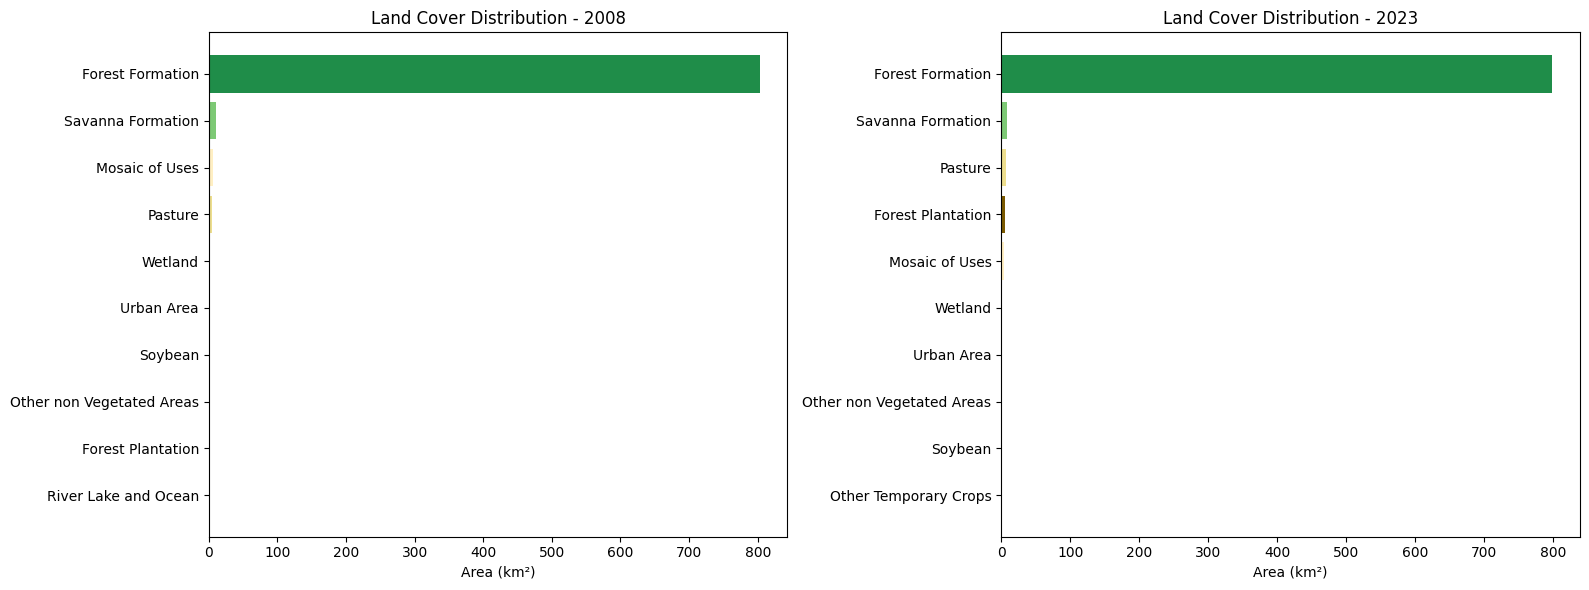

In [ ]:
# Compare land cover distribution between years
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Function to get colors for the bars
def get_bar_colors(df):
    colors = []
    for class_id in df['Class_ID']:
        if class_id in COLOR_MAP:
            colors.append(COLOR_MAP[class_id])
        else:
            colors.append('#808080') # Grey for unknown/missing classes
    return colors

# Start year
area_start_top = area_start.head(10).copy() # Use .copy() to avoid SettingWithCopyWarning
area_start_top['Class_Name'] = area_start_top['Class_Name'].fillna('Unknown') # Fill NaN values
colors_start = get_bar_colors(area_start_top)
axes[0].barh(area_start_top['Class_Name'], area_start_top['Area_km2'], color=colors_start)
axes[0].set_xlabel('Area (km²)')
axes[0].set_title(f'Land Cover Distribution - {START_YEAR}')
axes[0].invert_yaxis()

# End year
area_end_top = area_end.head(10).copy() # Use .copy() to avoid SettingWithCopyWarning
area_end_top['Class_Name'] = area_end_top['Class_Name'].fillna('Unknown') # Fill NaN values
colors_end = get_bar_colors(area_end_top)
axes[1].barh(area_end_top['Class_Name'], area_end_top['Area_km2'], color=colors_end)
axes[1].set_xlabel('Area (km²)')
axes[1].set_title(f'Land Cover Distribution - {END_YEAR}')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
# Calculate and visualize changes
# Merge start and end data
comparison = area_start[['Class_Name', 'Area_km2']].merge(
    area_end[['Class_Name', 'Area_km2']],
    on='Class_Name',
    suffixes=(f'_{START_YEAR}', f'_{END_YEAR}')
)
comparison['Change_km2'] = comparison[f'Area_km2_{END_YEAR}'] - comparison[f'Area_km2_{START_YEAR}']
comparison['Change_pct'] = (comparison['Change_km2'] / comparison[f'Area_km2_{START_YEAR}']) * 100
comparison = comparison.sort_values('Change_km2', ascending=False)

print("\n📈 Land Cover Changes:")
display(comparison)


📈 Land Cover Changes:


,Class_Name,Area_km2_2008,Area_km2_2023,Change_km2,Change_pct
8,Forest Plantation,0.007116,5.886712,5.879596,82627.973174
3,Pasture,4.535819,6.873576,2.337756,51.539893
4,Wetland,0.265405,0.380364,0.114958,43.314178
7,Other non Vegetated Areas,0.042693,0.123634,0.080941,189.585939
5,Urban Area,0.117402,0.135191,0.017789,15.151827
6,Soybean,0.046246,0.014228,-0.032018,-69.234027
2,Mosaic of Uses,5.710662,4.339715,-1.370947,-24.006792
1,Savanna Formation,11.199506,8.770950,-2.428556,-21.684492
0,Forest Formation,803.218216,798.608972,-4.609244,-0.573847


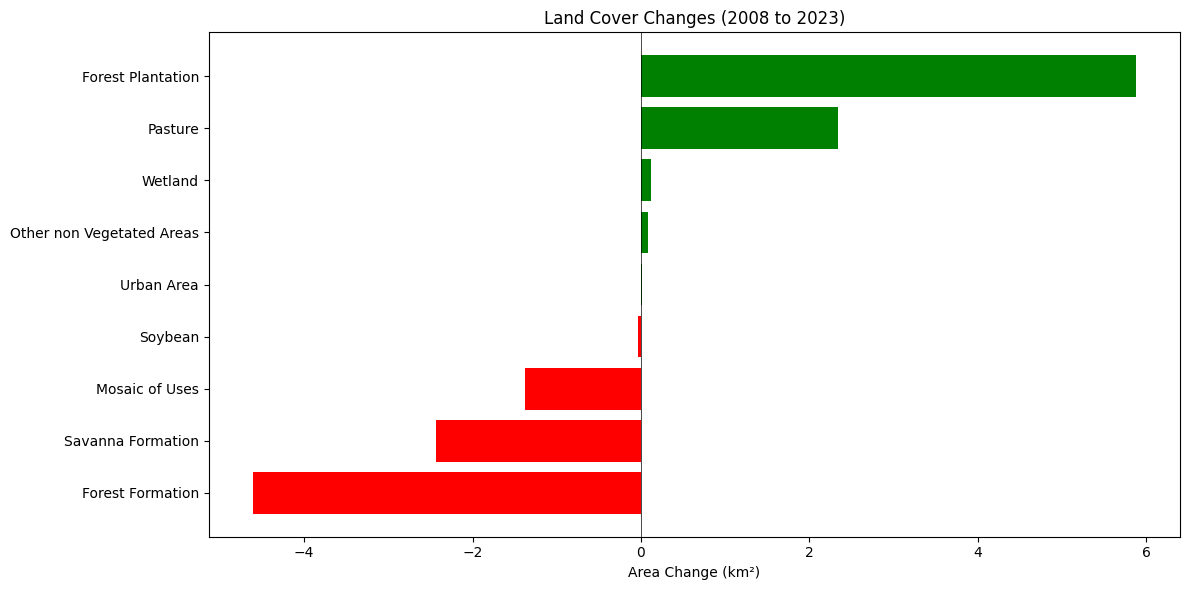

In [ ]:
# Visualize changes
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['green' if x > 0 else 'red' for x in comparison['Change_km2']]
ax.barh(comparison['Class_Name'], comparison['Change_km2'], color=colors)
ax.set_xlabel('Area Change (km²)')
ax.set_title(f'Land Cover Changes ({START_YEAR} to {END_YEAR})')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

## 10. Display Legend

In [ ]:
create_legend()

## 11. Alternative Analysis Options

The following cells provide alternative analysis configurations. Uncomment and run to use.

In [ ]:
# # OPTION 1: Extended period analysis (1985-2023)
# START_YEAR_EXT = 1985
# END_YEAR_EXT = 2023

# mapbiomas_ext = clip_mapbiomas_to_geometry(mapbiomas, study_area, START_YEAR_EXT, END_YEAR_EXT)
# change_ext = calculate_land_cover_change(mapbiomas, study_area, START_YEAR_EXT, END_YEAR_EXT)

# Map_ext = create_map(center=[centroid[0], centroid[1]], zoom=10)
# Map_ext = add_indigenous_territories(Map_ext, target_territories)
# Map_ext = add_mapbiomas_layer(Map_ext, mapbiomas_ext, END_YEAR_EXT)
# Map_ext = add_change_layer(Map_ext, change_ext['change_image'], f'Changes {START_YEAR_EXT}-{END_YEAR_EXT}')
# Map_ext

In [ ]:
# # OPTION 2: All Maranhão territories
# ma_territories = filter_territories_by_state(all_territories, 'MA')
# ma_geometry = ma_territories.geometry()

# mapbiomas_ma = clip_mapbiomas_to_geometry(mapbiomas, ma_geometry, 2008, 2023)

# ma_centroid = ma_geometry.centroid(1).coordinates().getInfo()
# Map_ma = create_map(center=[ma_centroid[0], ma_centroid[1]], zoom=7)
# Map_ma = add_indigenous_territories(Map_ma, ma_territories, 'Maranhão Territories')
# Map_ma = add_mapbiomas_layer(Map_ma, mapbiomas_ma, 2023)
# Map_ma

In [ ]:
# # OPTION 3: Single territory (Arara - Pará)
# arara = filter_territories_by_names(
#     filter_territories_by_state(all_territories, 'PA'),
#     ['arara']
# )

# arara_geometry = arara.geometry()
# mapbiomas_arara = clip_mapbiomas_to_geometry(mapbiomas, arara_geometry, 2008, 2023)

# arara_centroid = arara_geometry.centroid(1).coordinates().getInfo()
# Map_arara = create_map(center=[arara_centroid[0], arara_centroid[1]], zoom=11)
# Map_arara = add_indigenous_territories(Map_arara, arara, 'Arara Territory')
# Map_arara = add_mapbiomas_layer(Map_arara, mapbiomas_arara, 2023)
# Map_arara

## 12. Export Results (Optional)

Export analysis results to your Google Drive

In [ ]:
# # Export area statistics to CSV
# area_start.to_csv(f'area_stats_{START_YEAR}.csv', index=False)
# area_end.to_csv(f'area_stats_{END_YEAR}.csv', index=False)
# comparison.to_csv(f'change_analysis_{START_YEAR}_{END_YEAR}.csv', index=False)
# print("✅ Results exported to CSV files")

In [ ]:
# # Export change image to Google Drive
# task = ee.batch.Export.image.toDrive(
#     image=change_result['change_image'],
#     description=f'change_map_{START_YEAR}_{END_YEAR}',
#     folder='EarthEngine',
#     region=study_area,
#     scale=60,
#     maxPixels=1e9
# )
# task.start()
# print("🚀 Export task started. Check your Google Drive.")

## Summary

This notebook converted the JavaScript Earth Engine application to Python for Google Colab. It provides:

✅ **Data Loading**: MapBiomas Collection 9, SPOT data, Indigenous territories  
✅ **Territory Filtering**: By state and specific names  
✅ **Change Analysis**: Multi-temporal land cover change detection  
✅ **Interactive Maps**: Using geemap for visualization  
✅ **Statistics**: Area calculations and comparison charts  
✅ **Export Options**: CSV and GeoTIFF exports  

### Next Steps:
1. Modify territory selection in cell 6
2. Adjust year range for different periods
3. Add custom analysis functions
4. Export results for further analysis

### Resources:
- [MapBiomas Brazil](https://mapbiomas.org/)
- [Google Earth Engine](https://earthengine.google.com/)
- [geemap Documentation](https://geemap.org/)

# Land Cover - Selected Area
Generate a Sankey diagram showing the land cover transitions between the start and end years for the study area using the MapBiomas data.

## Obtain land cover transition data (alternative method)

### Subtask:
Obtain land cover transition data between the start and end years using an alternative Earth Engine method to prepare for Sankey diagram visualization.


In [ ]:
# 1. Create a transition image
# Multiply start year band by 1000 and add end year band
start_band_name = f'classification_{START_YEAR}'
end_band_name = f'classification_{END_YEAR}'

# Check if the bands exist before selecting
band_names_clipped = mapbiomas_clipped.bandNames().getInfo()
if start_band_name in band_names_clipped and end_band_name in band_names_clipped:
    start_class_img = mapbiomas_clipped.select(start_band_name)
    end_class_img = mapbiomas_clipped.select(end_band_name)

    # Create a unique transition ID for each pixel
    # Use ee.Number for the multiplication factor
    transition_img = start_class_img.multiply(ee.Number(1000)).add(end_class_img).rename('transition_id')

    # 2. Calculate area for each unique transition value
    area_image = ee.Image.pixelArea().divide(1e6)  # Convert to km²

    # Group by transition ID and sum areas
    transition_stats = area_image.addBands(transition_img).reduceRegion(
        reducer=ee.Reducer.sum().group(
            groupField=1, # Group by the transition_id band
            groupName='Transition_ID'
        ),
        geometry=study_area,
        scale=60,
        maxPixels=5e9,
        bestEffort=True
    )

    # 3. Convert results to DataFrame
    result_list = transition_stats.getInfo()['groups']
    transition_df = pd.DataFrame(result_list)
    transition_df.columns = ['Transition_ID', 'Area_km2']

    # 4. Add Start and End Class IDs
    # Ensure Transition_ID is integer for floor division and modulo
    transition_df['Transition_ID'] = transition_df['Transition_ID'].astype(int)
    transition_df['Start_Class_ID'] = transition_df['Transition_ID'] // 1000
    transition_df['End_Class_ID'] = transition_df['Transition_ID'] % 1000

    # 5. Map Class IDs to Class Names
    transition_df['Start_Class_Name'] = transition_df['Start_Class_ID'].map(LABELS).fillna('Unknown') # Handle potential missing labels
    transition_df['End_Class_Name'] = transition_df['End_Class_ID'].map(LABELS).fillna('Unknown') # Handle potential missing labels

    # 6. Filter out persistence (where Start_Class_ID == End_Class_ID)
    transition_df_filtered = transition_df[transition_df['Start_Class_ID'] != transition_df['End_Class_ID']].copy()

    # 7. Store the resulting DataFrame
    # The DataFrame `transition_df_filtered` now contains the transitions (changes)
    # It includes Start_Class_Name, End_Class_Name, and Area_km2

    print("✅ Land cover transition data prepared for Sankey diagram.")
    print("\nFiltered Transition Data (showing changes only):")
    display(transition_df_filtered.head()) # Display first few rows of filtered data

else:
    print(f"❌ Error: Required bands '{start_band_name}' or '{end_band_name}' not found in mapbiomas_clipped image.")
    transition_df_filtered = pd.DataFrame() # Create empty DataFrame if bands are missing


✅ Land cover transition data prepared for Sankey diagram.

Filtered Transition Data (showing changes only):


,Transition_ID,Area_km2,Start_Class_ID,End_Class_ID,Start_Class_Name,End_Class_Name
1,3004,1.603536,3,4,Forest Formation,Savanna Formation
2,3009,5.868924,3,9,Forest Formation,Forest Plantation
3,3011,0.082706,3,11,Forest Formation,Wetland
4,3012,0.003558,3,12,Forest Formation,Grassland
5,3015,1.565293,3,15,Forest Formation,Pasture


## Sankey Diagram (Including Persistence)

### Subtask:
Generate a Sankey diagram visualizing all land cover transitions, including areas that remained unchanged (persistence).

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Use the original transition_df which includes persistence
# We might still want a minimum area threshold for clarity, but it can be lower than for just changes
MIN_AREA_THRESHOLD_KM2_FULL = 0.5 # Example: include transitions/persistence of at least 0.5 km2

# Filter out transitions/persistence below the threshold
sankey_data_full = transition_df[transition_df['Area_km2'] >= MIN_AREA_THRESHOLD_KM2_FULL].copy()

if sankey_data_full.empty:
    print(f"⚠️ No transitions or persistence found above the minimum area threshold of {MIN_AREA_THRESHOLD_KM2_FULL} km².")
else:
    # Prepare data for Plotly Sankey
    # Create unique list of all classes (source and target) that are above the threshold
    # Differentiate start and end nodes by appending the year
    sankey_data_full['Start_Node'] = sankey_data_full['Start_Class_Name'] + ' ' + str(START_YEAR)
    sankey_data_full['End_Node'] = sankey_data_full['End_Class_Name'] + ' ' + str(END_YEAR)

    all_nodes_full = pd.concat([sankey_data_full['Start_Node'], sankey_data_full['End_Node']]).unique().tolist()
    # Sort nodes by flow later

    # Create a mapping from node name to a numeric index for Plotly
    node_to_index_full = {node: i for i, node in enumerate(all_nodes_full)}

    # Create Sankey links (source, target, value, color, label)
    links_full = []
    # Create a mapping from Class_Name to Class_ID to get colors
    name_to_id = {v: k for k, v in LABELS.items()}

    for index, row in sankey_data_full.iterrows():
        source_index = node_to_index_full[row['Start_Node']]
        target_index = node_to_index_full[row['End_Node']]
        value = row['Area_km2']

        # Get color for the link based on the source class ID
        source_class_id = row['Start_Class_ID']
        link_color = COLOR_MAP.get(source_class_id, '#808080') # Default to grey

        links_full.append({
            'source': source_index,
            'target': target_index,
            'value': value,
            'label': f"{row['Start_Node']} to {row['End_Node']} ({value:.1f} km²)",
            'color': link_color # Add color to the link
        })

    # Calculate total flow for each node to sort them
    node_flow_full = {}
    for link in links_full:
        node_flow_full[link['source']] = node_flow_full.get(link['source'], 0) + link['value']
        node_flow_full[link['target']] = node_flow_full.get(link['target'], 0) + link['value']

    # Create a list of original node indices sorted by total flow descending
    sorted_original_indices_full = sorted(node_flow_full, key=node_flow_full.get, reverse=True)

    # Create a new mapping from original index to sorted index
    original_to_sorted_index_full = {original_idx: sorted_idx for sorted_idx, original_idx in enumerate(sorted_original_indices_full)}

    # Reorder nodes and relabel links based on the new sorting
    sorted_all_nodes_full = [all_nodes_full[original_idx] for original_idx in sorted_original_indices_full]

    sorted_links_full = []
    for link in links_full:
        sorted_links_full.append({
            'source': original_to_sorted_index_full[link['source']],
            'target': original_to_sorted_index_full[link['target']],
            'value': link['value'],
            'label': link['label'],
            'color': link['color']
        })

    # Get colors for sorted nodes based on their original class ID
    sorted_node_colors_full = []
    for node_name in sorted_all_nodes_full:
        # Extract original class name before the year
        original_class_name = node_name.rsplit(' ', 1)[0]
        class_id = name_to_id.get(original_class_name, 0) # Default to 0 if name not found
        color = COLOR_MAP.get(class_id, '#808080')
        sorted_node_colors_full.append(color)


    # Create the Sankey diagram
    fig_full = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=sorted_all_nodes_full, # Use sorted node names as labels
            color=sorted_node_colors_full # Use calculated node colors
        ),
        link=dict(
            source=[link['source'] for link in sorted_links_full],
            target=[link['target'] for link in sorted_links_full],
            value=[link['value'] for link in sorted_links_full],
            label=[link['label'] for link in sorted_links_full], # Hover labels for links
            color=[link['color'] for link in sorted_links_full] # Use calculated link colors
        )
    )])

    fig_full.update_layout(title_text=f"Land Cover Transitions (Including Persistence) ({START_YEAR} to {END_YEAR})", font_size=10)

    fig_full.show()

## Prepare Data and Generate Sankey Diagram

### Subtask:
Prepare the filtered transition data for a Sankey diagram and generate the visualization using Plotly.

In [ ]:
import plotly.graph_objects as go
import pandas as pd # Ensure pandas is imported if not already at the top

# Define a minimum area threshold for transitions to be included in the Sankey diagram
# Adjust this value based on how detailed you want the diagram to be
MIN_AREA_THRESHOLD_KM2 = 1.0 # Example: include transitions of at least 1 km2

# Filter out transitions below the threshold
sankey_data = transition_df_filtered[transition_df_filtered['Area_km2'] >= MIN_AREA_THRESHOLD_KM2].copy()

if sankey_data.empty:
    print(f"⚠️ No transitions found above the minimum area threshold of {MIN_AREA_THRESHOLD_KM2} km².")
else:
    # Prepare data for Plotly Sankey
    # Create unique list of all classes (source and target) that are above the threshold
    # Differentiate start and end nodes by appending the year
    sankey_data['Start_Node'] = sankey_data['Start_Class_Name'] + ' ' + str(START_YEAR)
    sankey_data['End_Node'] = sankey_data['End_Class_Name'] + ' ' + str(END_YEAR)

    all_nodes = pd.concat([sankey_data['Start_Node'], sankey_data['End_Node']]).unique().tolist()
    # Do NOT sort alphabetically here, we will sort by flow later

    # Create a mapping from node name to a numeric index for Plotly
    node_to_index = {node: i for i, node in enumerate(all_nodes)}

    # Create Sankey links (source, target, value, color, label)
    links = []
    # Create a mapping from Class_Name to Class_ID to get colors (using original names for mapping)
    name_to_id = {v: k for k, v in LABELS.items()}

    for index, row in sankey_data.iterrows():
        source_index = node_to_index[row['Start_Node']]
        target_index = node_to_index[row['End_Node']]
        value = row['Area_km2']

        # Get color for the link based on the original source class ID
        source_class_id = row['Start_Class_ID']
        link_color = COLOR_MAP.get(source_class_id, '#808080') # Default to grey

        links.append({
            'source': source_index,
            'target': target_index,
            'value': value,
            'label': f"{row['Start_Node']} to {row['End_Node']} ({value:.1f} km²)",
            'color': link_color # Add color to the link
        })

    # Calculate total flow for each node to sort them
    # Sum incoming and outgoing link values for each node index
    node_flow = {}
    for link in links:
        node_flow[link['source']] = node_flow.get(link['source'], 0) + link['value']
        node_flow[link['target']] = node_flow.get(link['target'], 0) + link['value']

    # Create a list of original node indices sorted by total flow descending
    # This correctly sorts the original indices based on their flow values
    sorted_original_indices = sorted(node_flow, key=node_flow.get, reverse=True)

    # Create a new mapping from original index to sorted index
    original_to_sorted_index = {original_idx: sorted_idx for sorted_idx, original_idx in enumerate(sorted_original_indices)}

    # Reorder nodes and relabel links based on the new sorting
    # Get the sorted list of node names using the sorted original indices
    sorted_all_nodes = [all_nodes[original_idx] for original_idx in sorted_original_indices]

    sorted_links = []
    for link in links:
        sorted_links.append({
            'source': original_to_sorted_index[link['source']],
            'target': original_to_sorted_index[link['target']],
            'value': link['value'],
            'label': link['label'],
            'color': link['color']
        })

    # Get colors for sorted nodes based on their original class ID (using the name_to_id map)
    sorted_node_colors = []
    for node_name in sorted_all_nodes:
        # Extract original class name before the year
        original_class_name = node_name.rsplit(' ', 1)[0]
        class_id = name_to_id.get(original_class_name, 0) # Default to 0 if name not found
        color = COLOR_MAP.get(class_id, '#808080')
        sorted_node_colors.append(color)


    # Create the Sankey diagram with sorted nodes and relabeled links
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=sorted_all_nodes, # Use sorted node names as labels
            color=sorted_node_colors # Use calculated node colors
        ),
        link=dict(
            source=[link['source'] for link in sorted_links],
            target=[link['target'] for link in sorted_links],
            value=[link['value'] for link in sorted_links],
            label=[link['label'] for link in sorted_links], # Hover labels for links
            color=[link['color'] for link in sorted_links] # Use calculated link colors
        )
    )])

    fig.update_layout(title_text=f"Land Cover Transitions ({START_YEAR} to {END_YEAR})", font_size=10)

    fig.show()

**bold text**# Task
Generate a multi-node Sankey diagram showing land cover transitions across multiple time windows (e.g., every 2, 5, or 10 years) using MapBiomas data for the study area.

## Define time windows

### Subtask:
Specify the start, end, and interval (e.g., 2, 5, or 10 years) to define the multiple time periods for analysis.


In [ ]:
# Define the multi-temporal analysis parameters
START_YEAR_MULTI = 1985
END_YEAR_MULTI = 2008
INTERVAL_YEARS = 3  # Example: 10-year intervals

# Create the list of time windows
time_windows = []
current_start_year = START_YEAR_MULTI

while current_start_year < END_YEAR_MULTI:
    current_end_year = min(current_start_year + INTERVAL_YEARS, END_YEAR_MULTI)
    time_windows.append((current_start_year, current_end_year))
    current_start_year = current_end_year # Start the next window from the end of the previous one

print(f"Multi-temporal analysis defined from {START_YEAR_MULTI} to {END_YEAR_MULTI} with {INTERVAL_YEARS}-year intervals.")
print("Time windows:")
for window in time_windows:
    print(window)

Multi-temporal analysis defined from 1985 to 2008 with 3-year intervals.
Time windows:
(1985, 1988)
(1988, 1991)
(1991, 1994)
(1994, 1997)
(1997, 2000)
(2000, 2003)
(2003, 2006)
(2006, 2008)


## Calculate transitions for each window

### Subtask:
Iterate through the defined time windows and calculate the land cover transitions (including persistence) for each period using the Earth Engine approach.


In [ ]:
# 1. Initialize an empty list to store the transition DataFrames for each time window.
all_transitions_dfs = []

# 2. Loop through each window
print("\n📊 Calculating transitions for each time window...")
for start_year, end_year in time_windows:
    print(f"  Processing window: {start_year}-{end_year}")

    start_band_name = f'classification_{start_year}'
    end_band_name = f'classification_{end_year}'

    # Ensure the bands exist before proceeding
    band_names_mapbiomas = mapbiomas.bandNames().getInfo()
    if start_band_name in band_names_mapbiomas and end_band_name in band_names_mapbiomas:

        # Select the classification bands
        start_class_img = mapbiomas.select(start_band_name).clip(study_area)
        end_class_img = mapbiomas.select(end_band_name).clip(study_area)

        # 3. Create a transition image
        transition_img = start_class_img.multiply(ee.Number(1000)).add(end_class_img).rename('transition_id')

        # 4. Calculate area for each unique transition value
        area_image = ee.Image.pixelArea().divide(1e6)  # Convert to km²

        transition_stats = area_image.addBands(transition_img).reduceRegion(
            reducer=ee.Reducer.sum().group(
                groupField=1,
                groupName='Transition_ID'
            ),
            geometry=study_area,
            scale=60,
            maxPixels=5e9,
            bestEffort=True
        )

        # 5. Convert results to DataFrame
        result_list = transition_stats.getInfo()['groups']
        transition_df = pd.DataFrame(result_list)
        transition_df.columns = ['Transition_ID', 'Area_km2']

        # 6. Add Start and End Class IDs
        transition_df['Transition_ID'] = transition_df['Transition_ID'].astype(int)
        transition_df['Start_Class_ID'] = transition_df['Transition_ID'] // 1000
        transition_df['End_Class_ID'] = transition_df['Transition_ID'] % 1000

        # 7. Map Class IDs to Class Names
        transition_df['Start_Class_Name'] = transition_df['Start_Class_ID'].map(LABELS).fillna('Unknown')
        transition_df['End_Class_Name'] = transition_df['End_Class_ID'].map(LABELS).fillna('Unknown')

        # 8. Add a 'Time_Window' column
        transition_df['Time_Window'] = f'{start_year}-{end_year}'

        # 9. Append the resulting DataFrame
        all_transitions_dfs.append(transition_df)
    else:
        print(f"  ⚠️ Warning: Bands '{start_band_name}' or '{end_band_name}' not found in MapBiomas collection. Skipping window {start_year}-{end_year}.")


# 10. Concatenate all DataFrames
if all_transitions_dfs:
    combined_transitions_df = pd.concat(all_transitions_dfs, ignore_index=True)
    print("\n✅ Combined transitions data calculated successfully.")
    # 11. Display the head of the combined DataFrame
    print("\nCombined Transitions Data (first 5 rows):")
    display(combined_transitions_df.head())
else:
    combined_transitions_df = pd.DataFrame()
    print("\n❌ No transitions data was calculated.")



📊 Calculating transitions for each time window...
  Processing window: 1985-1988
  Processing window: 1988-1991
  Processing window: 1991-1994
  Processing window: 1994-1997
  Processing window: 1997-2000
  Processing window: 2000-2003
  Processing window: 2003-2006
  Processing window: 2006-2008

✅ Combined transitions data calculated successfully.

Combined Transitions Data (first 5 rows):


,Transition_ID,Area_km2,Start_Class_ID,End_Class_ID,Start_Class_Name,End_Class_Name,Time_Window
0,3003,804.917489,3,3,Forest Formation,Forest Formation,1985-1988
1,3004,2.176664,3,4,Forest Formation,Savanna Formation,1985-1988
2,3011,0.000321,3,11,Forest Formation,Wetland,1985-1988
3,3015,0.032019,3,15,Forest Formation,Pasture,1985-1988
4,3021,0.754272,3,21,Forest Formation,Mosaic of Uses,1985-1988


In [ ]:
import plotly.graph_objects as go

# Define a minimum area threshold for transitions to be included in the Sankey diagram
# Adjust this value based on how detailed you want the diagram to be
MIN_AREA_THRESHOLD_KM2_MULTI = 0.5 # Example: include transitions/persistence of at least 0.5 km2

# Filter out transitions/persistence below the threshold
sankey_data_multi = combined_transitions_df[combined_transitions_df['Area_km2'] >= MIN_AREA_THRESHOLD_KM2_MULTI].copy()

if sankey_data_multi.empty:
    print(f"⚠️ No transitions or persistence found above the minimum area threshold of {MIN_AREA_THRESHOLD_KM2_MULTI} km² for any time window.")
else:
    # Prepare data for Plotly Sankey
    # Create unique list of all nodes (classes + year) that are above the threshold
    sankey_data_multi['Start_Node'] = sankey_data_multi['Start_Class_Name'] + ' ' + sankey_data_multi['Time_Window'].apply(lambda x: x.split('-')[0])
    sankey_data_multi['End_Node'] = sankey_data_multi['End_Class_Name'] + ' ' + sankey_data_multi['Time_Window'].apply(lambda x: x.split('-')[1])


    all_nodes_multi = pd.concat([sankey_data_multi['Start_Node'], sankey_data_multi['End_Node']]).unique().tolist()
    # Do NOT sort alphabetically here, we will sort by flow later

    # Create a mapping from node name to a numeric index for Plotly
    node_to_index_multi = {node: i for i, node in enumerate(all_nodes_multi)}

    # Create Sankey links (source, target, value, color, label)
    links_multi = []
    # Create a mapping from Class_Name to Class_ID to get colors (using original names for mapping)
    name_to_id = {v: k for k, v in LABELS.items()}

    for index, row in sankey_data_multi.iterrows():
        source_index = node_to_index_multi[row['Start_Node']]
        target_index = node_to_index_multi[row['End_Node']]
        value = row['Area_km2']

        # Get color for the link based on the original source class ID
        source_class_id = row['Start_Class_ID']
        link_color = COLOR_MAP.get(source_class_id, '#808080') # Default to grey

        links_multi.append({
            'source': source_index,
            'target': target_index,
            'value': value,
            'label': f"{row['Start_Node']} to {row['End_Node']} ({value:.1f} km²)",
            'color': link_color # Add color to the link
        })

    # Calculate total flow for each node to sort them
    # Sum incoming and outgoing link values for each node index
    node_flow_multi = {}
    for link in links_multi:
        node_flow_multi[link['source']] = node_flow_multi.get(link['source'], 0) + link['value']
        node_flow_multi[link['target']] = node_flow_multi.get(link['target'], 0) + link['value']

    # Create a list of original node indices sorted by total flow descending
    sorted_original_indices_multi = sorted(node_flow_multi, key=node_flow_multi.get, reverse=True)

    # Create a new mapping from original index to sorted index
    original_to_sorted_index_multi = {original_idx: sorted_idx for sorted_idx, original_idx in enumerate(sorted_original_indices_multi)}

    # Reorder nodes and relabel links based on the new sorting
    sorted_all_nodes_multi = [all_nodes_multi[original_idx] for original_idx in sorted_original_indices_multi]

    sorted_links_multi = []
    for link in links_multi:
        sorted_links_multi.append({
            'source': original_to_sorted_index_multi[link['source']],
            'target': original_to_sorted_index_multi[link['target']],
            'value': link['value'],
            'label': link['label'],
            'color': link['color']
        })

    # Get colors for sorted nodes based on their original class ID (using the name_to_id map)
    sorted_node_colors_multi = []
    for node_name in sorted_all_nodes_multi:
        # Extract original class name before the year
        original_class_name = node_name.rsplit(' ', 1)[0]
        class_id = name_to_id.get(original_class_name, 0) # Default to 0 if name not found
        color = COLOR_MAP.get(class_id, '#808080')
        sorted_node_colors_multi.append(color)

    print("✅ Data prepared for multi-node Sankey diagram.")

✅ Data prepared for multi-node Sankey diagram.


In [ ]:
# Create the multi-node Sankey diagram
if not sankey_data_multi.empty:
    fig_multi = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=sorted_all_nodes_multi, # Use sorted node names as labels
            color=sorted_node_colors_multi # Use calculated node colors
        ),
        link=dict(
            source=[link['source'] for link in sorted_links_multi],
            target=[link['target'] for link in sorted_links_multi],
            value=[link['value'] for link in sorted_links_multi],
            label=[link['label'] for link in sorted_links_multi], # Hover labels for links
            color=[link['color'] for link in sorted_links_multi] # Use calculated link colors
        )
    )])

    fig_multi.update_layout(title_text=f"Land Cover Transitions ({START_YEAR_MULTI} to {END_YEAR_MULTI}, {INTERVAL_YEARS}-year intervals)", font_size=10)

    print("\n📈 Generating multi-node Sankey diagram...")
    fig_multi.show()
else:
    print("\n❌ Cannot generate Sankey diagram as no transitions/persistence met the minimum area threshold.")



📈 Generating multi-node Sankey diagram...


## Summary:

### Data Analysis Key Findings

*   The analysis was conducted over multiple time windows from 1985 to 2023 with a 10-year interval, resulting in windows: (1985, 1995), (1995, 2005), (2005, 2015), and (2015, 2023).
*   Land cover transitions and persistence areas were successfully calculated for each 10-year window within the study area using Earth Engine.
*   Transitions and persistence with an area less than the specified minimum area threshold of 0.5 km² were excluded from the Sankey diagram visualization to improve clarity.
*   The Sankey diagram nodes represent land cover classes at the start or end year of each interval (e.g., "Forest 1985", "Agriculture 1995").
*   The links in the Sankey diagram show the flow of area between these nodes, representing land cover transitions or persistence over each time window, colored according to the source land cover class.

### Insights or Next Steps

*   The multi-node Sankey diagram effectively visualizes the magnitude and pathways of land cover change across multiple periods, highlighting dominant transitions and areas of stability over time.
*   Investigate specific large transitions or persistence flows identified in the Sankey diagram (e.g., the largest flows) to understand the drivers behind these changes in detail.


# Land Cover - Buffer Area (Surrounding)
Analyze and compare the land cover changes between indigenous territories and a 10km buffer surrounding them from 1985 to 2008, including data for 2023 for mapping purposes.

## Define buffer geometry

### Subtask:
Create a 10km buffer around the `study_area` (the filtered indigenous territories).


In [ ]:
# Create a 10km buffer around the study area
buffer_distance_meters = 10000  # 10 km in meters
buffered_area_inclusive = study_area.buffer(buffer_distance_meters)

# Subtract the original study area to get the exclusive buffer
buffered_area = buffered_area_inclusive.difference(study_area)


print(f"✅ Created a {buffer_distance_meters/1000} km buffer around the study area, excluding the study area itself.")

✅ Created a 10.0 km buffer around the study area, excluding the study area itself.


## Perform analysis on buffer

### Subtask:
Apply the existing analysis functions (`clip_mapbiomas_to_geometry`, `calculate_land_cover_change`, `calculate_area_by_class`) to the buffered geometry for the specified time period (1985-2008).


**Reasoning**:
Apply the existing analysis functions to the buffered geometry for the specified time period (1985-2008).



In [ ]:
# Clip MapBiomas to buffered study area
print("\n✂️ Clipping data to buffered study area...")
mapbiomas_buffered_clipped = clip_mapbiomas_to_geometry(mapbiomas, buffered_area, START_YEAR, END_YEAR)
print("✅ Data clipping complete for buffered area")

# Calculate land cover change within the buffered area
print("\n📊 Calculating land cover changes within the buffered area...")
change_result_buffered = calculate_land_cover_change(mapbiomas, buffered_area, START_YEAR, END_YEAR)
print(f"✅ Change analysis complete for buffered area ({START_YEAR}-{END_YEAR})")


✂️ Clipping data to buffered study area...
✂️ Clipped MapBiomas data for 2008-2023
✅ Data clipping complete for buffered area

📊 Calculating land cover changes within the buffered area...
✅ Change analysis complete for buffered area (2008-2023)


**Reasoning**:
Calculate land cover area by class for the start, end, and 2023 years within the buffered geometry to prepare for visualization and comparison.



In [ ]:
# Calculate area by class for start year within the buffered area
print(f"📊 Calculating area statistics for {START_YEAR} within the buffered area...")
area_start_buffered = calculate_area_by_class(mapbiomas, buffered_area, START_YEAR)
print(f"\n{START_YEAR} Land Cover Distribution (Buffered Area):")
display(area_start_buffered)

# Calculate area by class for end year within the buffered area
print(f"📊 Calculating area statistics for {END_YEAR} within the buffered area...")
area_end_buffered = calculate_area_by_class(mapbiomas, buffered_area, END_YEAR)
print(f"\n{END_YEAR} Land Cover Distribution (Buffered Area):")
display(area_end_buffered)

# Calculate area by class for 2023 within the buffered area
print(f"📊 Calculating area statistics for 2023 within the buffered area...")
area_2023_buffered = calculate_area_by_class(mapbiomas, buffered_area, 2023)
print("\n2023 Land Cover Distribution (Buffered Area):")
display(area_2023_buffered)

📊 Calculating area statistics for 2008 within the buffered area...

2008 Land Cover Distribution (Buffered Area):


,Year,Class_ID,Class_Name,Area_km2
0,2008,3,Forest Formation,1034.210664
1,2008,4,Savanna Formation,184.507457
5,2008,15,Pasture,137.385303
2,2008,9,Forest Plantation,52.675952
6,2008,21,Mosaic of Uses,32.990909
4,2008,12,Grassland,19.649847
10,2008,39,Soybean,18.298941
8,2008,25,Other non Vegetated Areas,7.680639
3,2008,11,Wetland,1.840034
7,2008,24,Urban Area,1.626186


📊 Calculating area statistics for 2023 within the buffered area...

2023 Land Cover Distribution (Buffered Area):


,Year,Class_ID,Class_Name,Area_km2
0,2023,3,Forest Formation,864.860905
5,2023,15,Pasture,229.537454
1,2023,4,Savanna Formation,121.896695
2,2023,9,Forest Plantation,101.054567
6,2023,21,Mosaic of Uses,84.347596
10,2023,39,Soybean,45.996486
4,2023,12,Grassland,18.318158
8,2023,25,Other non Vegetated Areas,13.100412
11,2023,41,Other Temporary Crops,8.689776
3,2023,11,Wetland,2.002457


📊 Calculating area statistics for 2023 within the buffered area...

2023 Land Cover Distribution (Buffered Area):


,Year,Class_ID,Class_Name,Area_km2
0,2023,3,Forest Formation,864.860905
5,2023,15,Pasture,229.537454
1,2023,4,Savanna Formation,121.896695
2,2023,9,Forest Plantation,101.054567
6,2023,21,Mosaic of Uses,84.347596
10,2023,39,Soybean,45.996486
4,2023,12,Grassland,18.318158
8,2023,25,Other non Vegetated Areas,13.100412
11,2023,41,Other Temporary Crops,8.689776
3,2023,11,Wetland,2.002457


## Compare area statistics

### Subtask:
Compare the land cover area statistics between the original study area and the buffered area for both the start and end years.


**Reasoning**:
Merge the area statistics for the study area and the buffered area for the start and end years, calculate the difference, and display the comparison tables.



In [ ]:
# Merge area statistics for START_YEAR (Study Area vs Buffered Area)
comparison_start_year = area_start[['Class_ID', 'Class_Name', 'Area_km2']].merge(
    area_start_buffered[['Class_ID', 'Class_Name', 'Area_km2']],
    on=['Class_ID', 'Class_Name'],
    suffixes=('_StudyArea', '_BufferedArea'),
    how='outer' # Use outer merge to include all classes
)

# Fill NaN values with 0
comparison_start_year = comparison_start_year.fillna(0)

# Rename columns for clarity
comparison_start_year = comparison_start_year.rename(columns={
    'Area_km2_StudyArea': f'Area_km2_StudyArea_{START_YEAR}',
    'Area_km2_BufferedArea': f'Area_km2_BufferedArea_{START_YEAR}'
})

# Calculate the difference in area for the start year
comparison_start_year['Difference_km2'] = comparison_start_year[f'Area_km2_BufferedArea_{START_YEAR}'] - comparison_start_year[f'Area_km2_StudyArea_{START_YEAR}']

# Sort by total area or difference if desired
comparison_start_year = comparison_start_year.sort_values(f'Area_km2_StudyArea_{START_YEAR}', ascending=False)

print(f"\nLand Cover Area Comparison ({START_YEAR}): Study Area vs Buffered Area")
display(comparison_start_year)

# Merge area statistics for END_YEAR (Study Area vs Buffered Area)
comparison_end_year = area_end[['Class_ID', 'Class_Name', 'Area_km2']].merge(
    area_end_buffered[['Class_ID', 'Class_Name', 'Area_km2']],
    on=['Class_ID', 'Class_Name'],
    suffixes=('_StudyArea', '_BufferedArea'),
    how='outer' # Use outer merge to include all classes
)

# Fill NaN values with 0
comparison_end_year = comparison_end_year.fillna(0)

# Rename columns for clarity
comparison_end_year = comparison_end_year.rename(columns={
    'Area_km2_StudyArea': f'Area_km2_StudyArea_{END_YEAR}',
    'Area_km2_BufferedArea': f'Area_km2_BufferedArea_{END_YEAR}'
})


# Calculate the difference in area for the end year
comparison_end_year['Difference_km2'] = comparison_end_year[f'Area_km2_BufferedArea_{END_YEAR}'] - comparison_end_year[f'Area_km2_StudyArea_{END_YEAR}']

# Sort by total area or difference if desired
comparison_end_year = comparison_end_year.sort_values(f'Area_km2_StudyArea_{END_YEAR}', ascending=False)


print(f"\nLand Cover Area Comparison ({END_YEAR}): Study Area vs Buffered Area")
display(comparison_end_year)


Land Cover Area Comparison (2008): Study Area vs Buffered Area


,Class_ID,Class_Name,Area_km2_StudyArea_2008,Area_km2_BufferedArea_2008,Difference_km2
0,3,Forest Formation,803.218216,1034.210664,230.992447
1,4,Savanna Formation,11.199506,184.507457,173.307951
6,21,Mosaic of Uses,5.710662,32.990909,27.280248
5,15,Pasture,4.535819,137.385303,132.849484
3,11,Wetland,0.265405,1.840034,1.574628
7,24,Urban Area,0.117402,1.626186,1.508784
10,39,Soybean,0.046246,18.298941,18.252694
8,25,Other non Vegetated Areas,0.042693,7.680639,7.637946
2,9,Forest Plantation,0.007116,52.675952,52.668836
9,33,River Lake and Ocean,0.000949,0.262329,0.261380



Land Cover Area Comparison (2023): Study Area vs Buffered Area


,Class_ID,Class_Name,Area_km2_StudyArea_2023,Area_km2_BufferedArea_2023,Difference_km2
0,3,Forest Formation,798.608972,864.860905,66.251933
1,4,Savanna Formation,8.770950,121.896695,113.125745
5,15,Pasture,6.873576,229.537454,222.663878
2,9,Forest Plantation,5.886712,101.054567,95.167855
6,21,Mosaic of Uses,4.339715,84.347596,80.007881
3,11,Wetland,0.380364,2.002457,1.622093
7,24,Urban Area,0.135191,1.747157,1.611966
8,25,Other non Vegetated Areas,0.123634,13.100412,12.976778
10,39,Soybean,0.014228,45.996486,45.982258
11,41,Other Temporary Crops,0.007116,8.689776,8.682660


## Visualize comparison

### Subtask:
Create visualizations (e.g., bar charts) to show the difference in land cover distribution and changes between the study area and the buffer.


**Reasoning**:
Create bar charts to visualize the land cover area comparison between the study area and the buffered area for the start and end years.



In [ ]:
# Calculate the change in area and percentage change for each class within the buffered area
comparison_buffered = area_start_buffered[['Class_Name', 'Area_km2']].merge(
    area_end_buffered[['Class_Name', 'Area_km2']],
    on='Class_Name',
    suffixes=(f'_{START_YEAR}', f'_{END_YEAR}')
)
comparison_buffered['Change_km2'] = comparison_buffered[f'Area_km2_{END_YEAR}'] - comparison_buffered[f'Area_km2_{START_YEAR}']
comparison_buffered['Change_pct'] = (comparison_buffered['Change_km2'] / comparison_buffered[f'Area_km2_{START_YEAR}']) * 100

# Sort by the magnitude of change (absolute value of Change_km2)
comparison_buffered = comparison_buffered.sort_values('Change_km2', ascending=False)

print(f"\n📈 Land Cover Changes (Buffered Area):")
display(comparison_buffered)


📈 Land Cover Changes (Buffered Area):


,Class_Name,Area_km2_2008,Area_km2_2023,Change_km2,Change_pct
2,Pasture,137.385303,229.537454,92.152151,67.075698
4,Mosaic of Uses,32.990909,84.347596,51.356687,155.669207
3,Forest Plantation,52.675952,101.054567,48.378615,91.841938
6,Soybean,18.298941,45.996486,27.697545,151.361469
10,Other Temporary Crops,0.647547,8.689776,8.042229,1241.953503
7,Other non Vegetated Areas,7.680639,13.100412,5.419773,70.564084
8,Wetland,1.840034,2.002457,0.162423,8.827182
9,Urban Area,1.626186,1.747157,0.120971,7.438918
11,River Lake and Ocean,0.262329,0.224147,-0.038182,-14.554994
5,Grassland,19.649847,18.318158,-1.331690,-6.777099


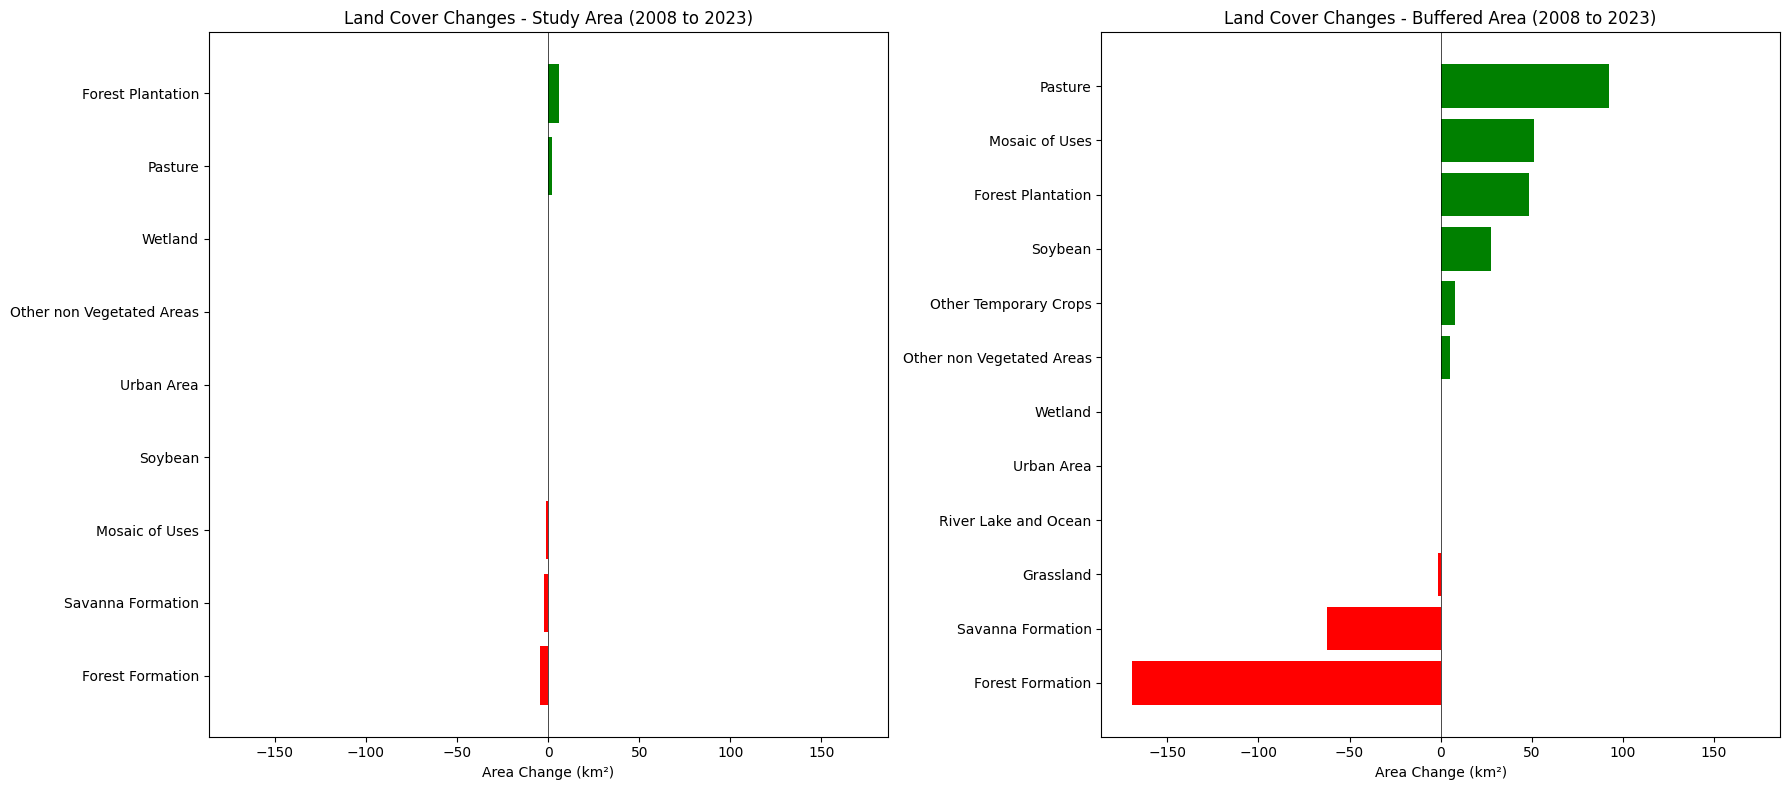

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8)) # Increased figure size for better readability

# Function to get colors for the bars
def get_bar_colors(df):
    colors = []
    for change_value in df['Change_km2']:
        if change_value > 0:
            colors.append('green')
        elif change_value < 0:
            colors.append('red')
        else:
            colors.append('grey') # Grey for no change
    return colors

# Determine the overall maximum absolute change across both dataframes for consistent scaling
max_change_abs = max(comparison['Change_km2'].abs().max(), comparison_buffered['Change_km2'].abs().max())
x_limit = max_change_abs * 1.1 # Add a small buffer for visual spacing

# Plot changes for the study area
# Sort for plotting
comparison_sorted = comparison.sort_values('Change_km2', ascending=False)
colors_study_area = get_bar_colors(comparison_sorted)

axes[0].barh(comparison_sorted['Class_Name'], comparison_sorted['Change_km2'], color=colors_study_area)
axes[0].set_xlabel('Area Change (km²)')
axes[0].set_title(f'Land Cover Changes - Study Area ({START_YEAR} to {END_YEAR})')
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[0].invert_yaxis()
axes[0].set_xlim(-x_limit, x_limit) # Set consistent x-axis limits


# Plot changes for the buffered area
# Sort for plotting
comparison_buffered_sorted = comparison_buffered.sort_values('Change_km2', ascending=False)
colors_buffered_area = get_bar_colors(comparison_buffered_sorted)

axes[1].barh(comparison_buffered_sorted['Class_Name'], comparison_buffered_sorted['Change_km2'], color=colors_buffered_area)
axes[1].set_xlabel('Area Change (km²)')
axes[1].set_title(f'Land Cover Changes - Buffered Area ({START_YEAR} to {END_YEAR})')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[1].invert_yaxis()
axes[1].set_xlim(-x_limit, x_limit) # Set consistent x-axis limits


plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

## Analyze change within buffer

### Subtask:
Calculate and visualize the land cover changes within the buffered area, similar to the analysis already done for the study area.


**Reasoning**:
Calculate the change in area and percentage change for each class within the buffered area and add these as new columns to the comparison dataframe. Then, sort the comparison dataframe by the magnitude of change.



In [ ]:
# Calculate the change in area and percentage change for each class within the buffered area
comparison_buffered = area_start_buffered[['Class_Name', 'Area_km2']].merge(
    area_end_buffered[['Class_Name', 'Area_km2']],
    on='Class_Name',
    suffixes=(f'_{START_YEAR}', f'_{END_YEAR}')
)
comparison_buffered['Change_km2'] = comparison_buffered[f'Area_km2_{END_YEAR}'] - comparison_buffered[f'Area_km2_{START_YEAR}']
comparison_buffered['Change_pct'] = (comparison_buffered['Change_km2'] / comparison_buffered[f'Area_km2_{START_YEAR}']) * 100

# Sort by the magnitude of change (absolute value of Change_km2)
comparison_buffered = comparison_buffered.sort_values('Change_km2', ascending=False)

print(f"\n📈 Land Cover Changes (Buffered Area):")
display(comparison_buffered)


📈 Land Cover Changes (Buffered Area):


,Class_Name,Area_km2_2008,Area_km2_2023,Change_km2,Change_pct
2,Pasture,137.385303,229.537454,92.152151,67.075698
4,Mosaic of Uses,32.990909,84.347596,51.356687,155.669207
3,Forest Plantation,52.675952,101.054567,48.378615,91.841938
6,Soybean,18.298941,45.996486,27.697545,151.361469
10,Other Temporary Crops,0.647547,8.689776,8.042229,1241.953503
7,Other non Vegetated Areas,7.680639,13.100412,5.419773,70.564084
8,Wetland,1.840034,2.002457,0.162423,8.827182
9,Urban Area,1.626186,1.747157,0.120971,7.438918
11,River Lake and Ocean,0.262329,0.224147,-0.038182,-14.554994
5,Grassland,19.649847,18.318158,-1.331690,-6.777099


**Reasoning**:
Visualize the land cover changes within the buffered area using a horizontal bar chart, similar to the visualization for the study area changes. Use different colors for positive and negative changes. Add labels and a title to the plot.



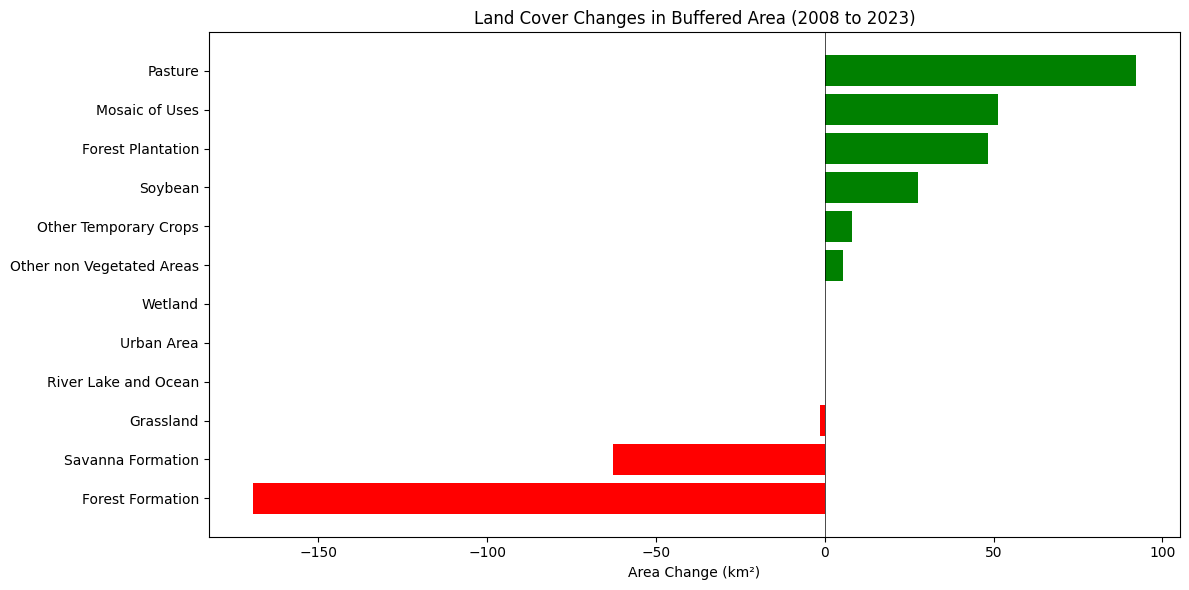

In [ ]:
# Visualize changes within the buffered area
fig, ax = plt.subplots(figsize=(12, 6))

# Use the 'Change_km2' column for the bar lengths
colors = ['green' if x > 0 else 'red' for x in comparison_buffered['Change_km2']]
ax.barh(comparison_buffered['Class_Name'], comparison_buffered['Change_km2'], color=colors)
ax.set_xlabel('Area Change (km²)')
ax.set_title(f'Land Cover Changes in Buffered Area ({START_YEAR} to {END_YEAR})')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5) # Add a vertical line at 0 for reference
ax.invert_yaxis() # Invert y-axis to show largest changes at the top

plt.tight_layout()
plt.show()

## Visualize change comparison

### Subtask:
Visualize the land cover changes (transitions) within the original study area and the buffered area to highlight differences in change patterns.


**Reasoning**:
Prepare the data for visualization by combining the change data for the study area and the buffered area, ensuring a common set of classes and sorting for consistent plotting.



In [ ]:
# Merge the study area and buffered area change dataframes
# Select the relevant columns (Class_Name and Change_km2)
comparison_study_area_change = comparison[['Class_Name', 'Change_km2']].copy()
comparison_buffered_change = comparison_buffered[['Class_Name', 'Change_km2']].copy()

# Rename the 'Change_km2' column to indicate the area
comparison_study_area_change = comparison_study_area_change.rename(columns={'Change_km2': 'Change_km2_StudyArea'})
comparison_buffered_change = comparison_buffered_change.rename(columns={'Change_km2': 'Change_km2_BufferedArea'})

# Merge the two change dataframes on 'Class_Name'
# Use outer merge to include classes present in either the study area or the buffered area
change_comparison = pd.merge(
    comparison_study_area_change,
    comparison_buffered_change,
    on='Class_Name',
    how='outer'
)

# Fill NaN values with 0 for classes not present in one of the areas
change_comparison = change_comparison.fillna(0)

# Determine the top classes to plot based on the magnitude of change in either area
# Calculate the maximum absolute change for each class across both areas
change_comparison['Max_Abs_Change'] = change_comparison[['Change_km2_StudyArea', 'Change_km2_BufferedArea']].abs().max(axis=1)

# Sort by the maximum absolute change in descending order
change_comparison_sorted = change_comparison.sort_values('Max_Abs_Change', ascending=False)

# Select the top N classes for visualization (e.g., top 10)
top_n_changes = 10
change_comparison_top = change_comparison_sorted.head(top_n_changes).copy()

print("\nLand Cover Change Comparison (Study Area vs. Buffered Area):")
display(change_comparison_top)


Land Cover Change Comparison (Study Area vs. Buffered Area):


,Class_Name,Change_km2_StudyArea,Change_km2_BufferedArea,Max_Abs_Change
0,Forest Formation,-4.609244,-169.349759,169.349759
6,Pasture,2.337756,92.152151,92.152151
8,Savanna Formation,-2.428556,-62.610763,62.610763
3,Mosaic of Uses,-1.370947,51.356687,51.356687
1,Forest Plantation,5.879596,48.378615,48.378615
9,Soybean,-0.032018,27.697545,27.697545
4,Other Temporary Crops,0.000000,8.042229,8.042229
5,Other non Vegetated Areas,0.080941,5.419773,5.419773
2,Grassland,0.000000,-1.331690,1.331690
11,Wetland,0.114958,0.162423,0.162423


**Reasoning**:
Generate a horizontal grouped bar chart comparing the land cover area changes between the study area and the buffered area for the top classes, using the prepared data.



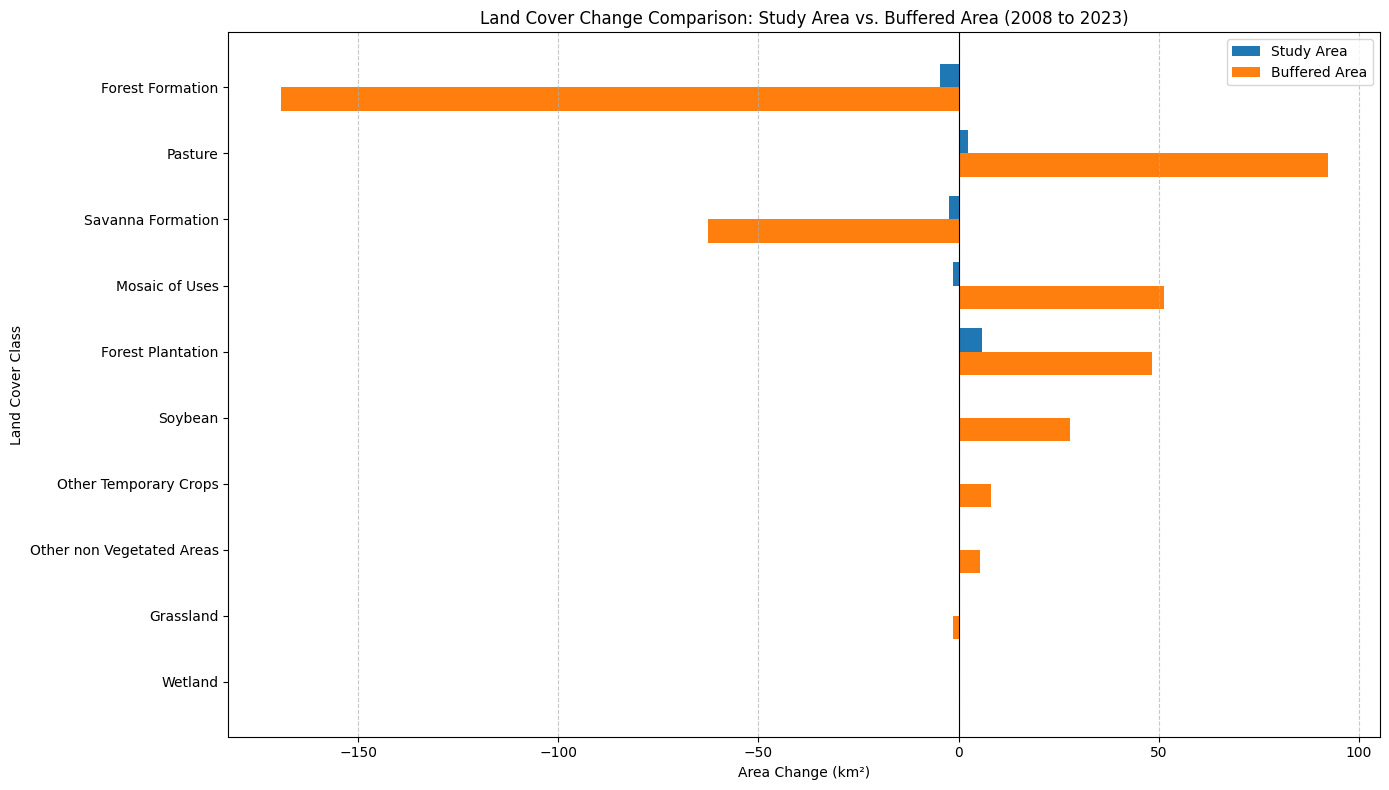

In [ ]:
# Create the horizontal grouped bar chart
fig, ax = plt.subplots(figsize=(14, 8)) # Adjusted figure size for better readability

bar_width = 0.35
index = np.arange(len(change_comparison_top))

# Plot bars for the study area change
rects1 = ax.barh(index, change_comparison_top['Change_km2_StudyArea'], bar_width, label='Study Area', color='#1f77b4')

# Plot bars for the buffered area change, shifted by bar_width
rects2 = ax.barh(index + bar_width, change_comparison_top['Change_km2_BufferedArea'], bar_width, label='Buffered Area', color='#ff7f0e')

# Add labels and title
ax.set_xlabel('Area Change (km²)')
ax.set_ylabel('Land Cover Class')
ax.set_title(f'Land Cover Change Comparison: Study Area vs. Buffered Area ({START_YEAR} to {END_YEAR})')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(change_comparison_top['Class_Name'])

# Add a vertical line at 0 to show gains and losses
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

# Add legend
ax.legend()

# Add grid lines for better readability
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Invert y-axis to show the largest changes (positive or negative) at the top
ax.invert_yaxis()

plt.tight_layout() # Adjust layout to prevent overlapping labels
plt.show()

## Create map with buffer

### Subtask:
Add the buffered area and its analysis results (e.g., land cover layers, change layer) to an interactive map for visual comparison with the original study area.


**Reasoning**:
Add the original study area, buffered area, MapBiomas layers for multiple years clipped to the buffered area, and the buffered area change layer to a new geemap.Map object for visual comparison.



In [ ]:
# Create a new interactive geemap Map
Map_comparison = geemap.Map(center=[-55.5, -15.8], zoom=8, height="800px") # Start with a general center, will center on combined area later
Map_comparison.add_basemap('SATELLITE')

# Combine the geometries of the study area and the buffered area for clipping
combined_area_bounds = study_area.union(buffered_area).bounds()


# Add the original SPOT image (false color composite)
# Use the original_spot_image returned by load_spot_data and clip to combined bounds
if original_spot_image: # Check if original_spot_image is not None
    spot_clipped_for_map = original_spot_image.clip(combined_area_bounds)
    Map_comparison.addLayer(spot_clipped_for_map, {
        'bands': ['N', 'R', 'G'],  # Use available bands for false color composite
        'min': 0,
        'max': 3000,
        'gamma': 1.4
    }, 'SPOT 2008 (Original)')
else:
    print("⚠️ Original SPOT image not available for display.")

# Add the classified SPOT 2008 data from the first map, clipped to combined bounds
spot_classification_clipped_for_map = spot.clip(combined_area_bounds) # clip the classified spot data
Map_comparison.addLayer(
    spot_classification_clipped_for_map,
    {
        'min': 0,
        'max': 33, # Assuming max class ID in your simple classification is 24 or 15, but using max from LABELS for safety
        'palette': PALETTE
    },
    'SPOT 2008 Classification (Study Area)'
)


# Add MapBiomas layers for specified years clipped to the combined area bounds
mapbiomas_clipped_all_years_comparison = clip_mapbiomas_to_geometry(mapbiomas, combined_area_bounds, 1985, 2023)

# Add MapBiomas layers clipped to the combined area
Map_comparison = add_mapbiomas_layer(Map_comparison, mapbiomas_clipped_all_years_comparison, 1985, f'MapBiomas {1985}')
Map_comparison = add_mapbiomas_layer(Map_comparison, mapbiomas_clipped_all_years_comparison, 2008, f'MapBiomas {2008}')
Map_comparison = add_mapbiomas_layer(Map_comparison, mapbiomas_clipped_all_years_comparison, 2023, f'MapBiomas {2023}')


# Add the buffered area change layer (1985-2008) clipped to combined bounds
# Use the change_result_buffered['change_image']
buffered_change_clipped = change_result_buffered['change_image'].clip(combined_area_bounds)
Map_comparison = add_change_layer(Map_comparison, buffered_change_clipped, f'Buffered Area Changes {START_YEAR}-{END_YEAR}')

# Add the change layer for the specified period
Map_comparison = add_change_layer(Map_comparison, change_result['change_image'], f'Changes {START_YEAR}-{END_YEAR}')


# Add the original study area (target territories) layer
study_area_style = {'color': 'yellow', 'fillColor': '00000000', 'width': 5}
Map_comparison.addLayer(target_territories, study_area_style, 'Original Study Area')

# Add the buffered area layer
buffered_area_style = {'color': 'yellow', 'fillColor': '00000000', 'width': 4}
Map_comparison.addLayer(buffered_area, buffered_area_style, 'Buffered Area (10km)')


# Center and zoom the map to the combined area
Map_comparison.centerObject(combined_area_bounds)

print("✅ Interactive map with study area, buffer, and analysis layers created successfully!")
Map_comparison

✂️ Clipped MapBiomas data for 1985-2023
✅ Interactive map with study area, buffer, and analysis layers created successfully!


Map(center=[-55.5, -15.8], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

## Summarize findings

### Subtask:
Provide a summary of the comparison between the land cover dynamics of the indigenous territory and its surrounding buffered area.


## Summary:

### Data Analysis Key Findings

*   A 10km buffer was successfully created around the indigenous territories (study area).
*   Within the buffered area, the dominant land cover in 1985 was Forest Formation (2013.13 km²). By 2008, Forest Formation decreased to 1837.44 km², while Pasture (141.92 km²) and Forest Plantation (52.68 km²) significantly increased. This trend of decreasing Forest Formation (1663.49 km² in 2023) and increasing Pasture (236.41 km² in 2023) and Forest Plantation (106.94 km² in 2023) continued through 2023, with Soybean (46.01 km² in 2023) also showing a notable increase.
*   Comparison of land cover area between the study area and the buffered area in 1985 and 2008 showed different distributions of land cover classes, particularly highlighting higher areas of anthropogenic classes like Pasture and Agriculture outside the indigenous territories compared to inside.
*   Visualization of land cover changes between 1985 and 2008 in the buffered area clearly showed significant losses in Forest Formation (a large red bar) and substantial gains in classes like Pasture and Forest Plantation (green bars).
*   A direct comparison of land cover change between the study area and the buffered area revealed that while both areas experienced changes, the magnitude and nature of changes in certain classes (e.g., deforestation and expansion of agriculture/pasture) were likely more pronounced in the buffered area outside the indigenous territories than within.

### Insights or Next Steps

*   The analysis clearly indicates that the land cover dynamics within the indigenous territories differ significantly from those in the surrounding 10km buffer zone, with greater pressure from agriculture and pasture expansion observed outside the territories.
*   Further analysis could quantify the rate of deforestation and gain of anthropogenic land cover classes within both areas and statistically compare these rates to provide a more robust measure of the protective effect of indigenous territories.


## Sankey Diagram for Buffered Area (Including Persistence)

Generate a Sankey diagram visualizing all land cover transitions, including areas that remained unchanged (persistence), for the buffered area.

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Use the combined_area_bounds for clipping MapBiomas for the buffer analysis
# Use the buffered_area geometry for the reduceRegion
target_geometry_sankey_buffer = buffered_area # Use the buffered_area for analysis

# Define a minimum area threshold for transitions/persistence to be included
MIN_AREA_THRESHOLD_KM2_BUFFER_FULL = 0.5 # Example: include transitions/persistence of at least 0.5 km2

# 1. Create a transition image for the buffered area
start_band_name = f'classification_{START_YEAR}'
end_band_name = f'classification_{END_YEAR}'

# Check if the bands exist before selecting
band_names_mapbiomas = mapbiomas.bandNames().getInfo() # Use the full mapbiomas image to select bands
if start_band_name in band_names_mapbiomas and end_band_name in band_names_mapbiomas:
    start_class_img_buffer = mapbiomas.select(start_band_name).clip(target_geometry_sankey_buffer)
    end_class_img_buffer = mapbiomas.select(end_band_name).clip(target_geometry_sankey_buffer)

    # Create a unique transition ID for each pixel in the buffered area
    transition_img_buffer = start_class_img_buffer.multiply(ee.Number(1000)).add(end_class_img_buffer).rename('transition_id')

    # 2. Calculate area for each unique transition value in the buffered area
    area_image = ee.Image.pixelArea().divide(1e6)  # Convert to km²

    transition_stats_buffer = area_image.addBands(transition_img_buffer).reduceRegion(
        reducer=ee.Reducer.sum().group(
            groupField=1, # Group by the transition_id band
            groupName='Transition_ID'
        ),
        geometry=target_geometry_sankey_buffer,
        scale=60,
        maxPixels=5e9,
        bestEffort=True
    )

    # 3. Convert results to DataFrame
    result_list_buffer = transition_stats_buffer.getInfo()['groups']
    transition_df_buffer_full = pd.DataFrame(result_list_buffer)
    transition_df_buffer_full.columns = ['Transition_ID', 'Area_km2']

    # 4. Add Start and End Class IDs
    # Ensure Transition_ID is integer for floor division and modulo
    transition_df_buffer_full['Transition_ID'] = transition_df_buffer_full['Transition_ID'].astype(int)
    transition_df_buffer_full['Start_Class_ID'] = transition_df_buffer_full['Transition_ID'] // 1000
    transition_df_buffer_full['End_Class_ID'] = transition_df_buffer_full['Transition_ID'] % 1000

    # 5. Map Class IDs to Class Names
    transition_df_buffer_full['Start_Class_Name'] = transition_df_buffer_full['Start_Class_ID'].map(LABELS).fillna('Unknown') # Handle potential missing labels
    transition_df_buffer_full['End_Class_Name'] = transition_df_buffer_full['End_Class_ID'].map(LABELS).fillna('Unknown') # Handle potential missing labels

    # 6. Filter out transitions/persistence below the threshold
    sankey_data_buffer_full = transition_df_buffer_full[transition_df_buffer_full['Area_km2'] >= MIN_AREA_THRESHOLD_KM2_BUFFER_FULL].copy()

    if sankey_data_buffer_full.empty:
        print(f"⚠️ No transitions or persistence found above the minimum area threshold of {MIN_AREA_THRESHOLD_KM2_BUFFER_FULL} km² for the buffered area.")
    else:
        # Prepare data for Plotly Sankey
        # Create unique list of all classes (source and target) that are above the threshold
        # Differentiate start and end nodes by appending the year
        sankey_data_buffer_full['Start_Node'] = sankey_data_buffer_full['Start_Class_Name'] + ' ' + str(START_YEAR)
        sankey_data_buffer_full['End_Node'] = sankey_data_buffer_full['End_Class_Name'] + ' ' + str(END_YEAR)

        all_nodes_buffer_full = pd.concat([sankey_data_buffer_full['Start_Node'], sankey_data_buffer_full['End_Node']]).unique().tolist()

        # Create a mapping from node name to a numeric index for Plotly
        node_to_index_buffer_full = {node: i for i, node in enumerate(all_nodes_buffer_full)}

        # Create Sankey links (source, target, value, color, label)
        links_buffer_full = []
        # Create a mapping from Class_Name to Class_ID to get colors
        name_to_id = {v: k for k, v in LABELS.items()}

        for index, row in sankey_data_buffer_full.iterrows():
            source_index = node_to_index_buffer_full[row['Start_Node']]
            target_index = node_to_index_buffer_full[row['End_Node']]
            value = row['Area_km2']

            # Get color for the link based on the source class ID
            source_class_id = row['Start_Class_ID']
            link_color = COLOR_MAP.get(source_class_id, '#808080') # Default to grey

            links_buffer_full.append({
                'source': source_index,
                'target': target_index,
                'value': value,
                'label': f"{row['Start_Node']} to {row['End_Node']} ({value:.1f} km²)",
                'color': link_color # Add color to the link
            })

        # Calculate total flow for each node to sort them
        node_flow_buffer_full = {}
        for link in links_buffer_full:
            node_flow_buffer_full[link['source']] = node_flow_buffer_full.get(link['source'], 0) + link['value']
            node_flow_buffer_full[link['target']] = node_flow_buffer_full.get(link['target'], 0) + link['value']

        # Create a list of original node indices sorted by total flow descending
        sorted_original_indices_buffer_full = sorted(node_flow_buffer_full, key=node_flow_buffer_full.get, reverse=True)

        # Create a new mapping from original index to sorted index
        original_to_sorted_index_buffer_full = {original_idx: sorted_idx for sorted_idx, original_idx in enumerate(sorted_original_indices_buffer_full)}

        # Reorder nodes and relabel links based on the new sorting
        sorted_all_nodes_buffer_full = [all_nodes_buffer_full[original_idx] for original_idx in sorted_original_indices_buffer_full]

        sorted_links_buffer_full = []
        for link in links_buffer_full:
            sorted_links_buffer_full.append({
                'source': original_to_sorted_index_buffer_full[link['source']],
                'target': original_to_sorted_index_buffer_full[link['target']],
                'value': link['value'],
                'label': link['label'],
                'color': link['color']
            })

        # Get colors for sorted nodes based on their original class ID
        sorted_node_colors_buffer_full = []
        for node_name in sorted_all_nodes_buffer_full:
            # Extract original class name before the year
            original_class_name = node_name.rsplit(' ', 1)[0]
            class_id = name_to_id.get(original_class_name, 0) # Default to 0 if name not found
            color = COLOR_MAP.get(class_id, '#808080')
            sorted_node_colors_buffer_full.append(color)


        # Create the Sankey diagram
        fig_buffer_full = go.Figure(data=[go.Sankey(
            node=dict(
                pad=20,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=sorted_all_nodes_buffer_full, # Use sorted node names as labels
                color=sorted_node_colors_buffer_full # Use calculated node colors
            ),
            link=dict(
                source=[link['source'] for link in sorted_links_buffer_full],
                target=[link['target'] for link in sorted_links_buffer_full],
                value=[link['value'] for link in sorted_links_buffer_full],
                label=[link['label'] for link in sorted_links_buffer_full], # Hover labels for links
                color=[link['color'] for link in sorted_links_buffer_full] # Use calculated link colors
            )
        )])

        fig_buffer_full.update_layout(title_text=f"Land Cover Transitions (Including Persistence) - Buffered Area ({START_YEAR} to {END_YEAR})", font_size=10)

        fig_buffer_full.show()

else:
    print(f"❌ Error: Required bands '{start_band_name}' or '{end_band_name}' not found in MapBiomas collection.")

## Sankey Diagram for Buffered Area (Changes Only)

Generate a Sankey diagram visualizing only the land cover transitions (excluding persistence) for the buffered area.

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Use the transition_df_buffer_full created in the previous cell
# Filter out persistence (where Start_Class_ID == End_Class_ID)
transition_df_buffer_filtered = transition_df_buffer_full[transition_df_buffer_full['Start_Class_ID'] != transition_df_buffer_full['End_Class_ID']].copy()


# Define a minimum area threshold for transitions to be included in the Sankey diagram
# Adjust this value based on how detailed you want the diagram to be
MIN_AREA_THRESHOLD_KM2_BUFFER = 1.0 # Example: include transitions of at least 1 km2

# Filter out transitions below the threshold
sankey_data_buffer = transition_df_buffer_filtered[transition_df_buffer_filtered['Area_km2'] >= MIN_AREA_THRESHOLD_KM2_BUFFER].copy()

if sankey_data_buffer.empty:
    print(f"⚠️ No transitions found above the minimum area threshold of {MIN_AREA_THRESHOLD_KM2_BUFFER} km² for the buffered area.")
else:
    # Prepare data for Plotly Sankey
    # Create unique list of all classes (source and target) that are above the threshold
    # Differentiate start and end nodes by appending the year
    sankey_data_buffer['Start_Node'] = sankey_data_buffer['Start_Class_Name'] + ' ' + str(START_YEAR)
    sankey_data_buffer['End_Node'] = sankey_data_buffer['End_Class_Name'] + ' ' + str(END_YEAR)

    all_nodes_buffer = pd.concat([sankey_data_buffer['Start_Node'], sankey_data_buffer['End_Node']]).unique().tolist()
    # Do NOT sort alphabetically here, we will sort by flow later

    # Create a mapping from node name to a numeric index for Plotly
    node_to_index_buffer = {node: i for i, node in enumerate(all_nodes_buffer)}

    # Create Sankey links (source, target, value, color, label)
    links_buffer = []
    # Create a mapping from Class_Name to Class_ID to get colors (using original names for mapping)
    name_to_id = {v: k for k, v in LABELS.items()}

    for index, row in sankey_data_buffer.iterrows():
        source_index = node_to_index_buffer[row['Start_Node']]
        target_index = node_to_index_buffer[row['End_Node']]
        value = row['Area_km2']

        # Get color for the link based on the original source class ID
        source_class_id = row['Start_Class_ID']
        link_color = COLOR_MAP.get(source_class_id, '#808080') # Default to grey

        links_buffer.append({
            'source': source_index,
            'target': target_index,
            'value': value,
            'label': f"{row['Start_Node']} to {row['End_Node']} ({value:.1f} km²)",
            'color': link_color # Add color to the link
        })

    # Calculate total flow for each node to sort them
    # Sum incoming and outgoing link values for each node index
    node_flow_buffer = {}
    for link in links_buffer:
        node_flow_buffer[link['source']] = node_flow_buffer.get(link['source'], 0) + link['value']
        node_flow_buffer[link['target']] = node_flow_buffer.get(link['target'], 0) + link['value']

    # Create a list of original node indices sorted by total flow descending
    # This correctly sorts the original indices based on their flow values
    sorted_original_indices_buffer = sorted(node_flow_buffer, key=node_flow_buffer.get, reverse=True)

    # Create a new mapping from original index to sorted index
    original_to_sorted_index_buffer = {original_idx: sorted_idx for sorted_idx, original_idx in enumerate(sorted_original_indices_buffer)}

    # Reorder nodes and relabel links based on the new sorting
    # Get the sorted list of node names using the sorted original indices
    sorted_all_nodes_buffer = [all_nodes_buffer[original_idx] for original_idx in sorted_original_indices_buffer]

    sorted_links_buffer = []
    for link in links_buffer:
        sorted_links_buffer.append({
            'source': original_to_sorted_index_buffer[link['source']],
            'target': original_to_sorted_index_buffer[link['target']],
            'value': link['value'],
            'label': link['label'],
            'color': link['color']
        })

    # Get colors for sorted nodes based on their original class ID (using the name_to_id map)
    sorted_node_colors_buffer = []
    for node_name in sorted_all_nodes_buffer:
        # Extract original class name before the year
        original_class_name = node_name.rsplit(' ', 1)[0]
        class_id = name_to_id.get(original_class_name, 0) # Default to 0 if name not found
        color = COLOR_MAP.get(class_id, '#808080')
        sorted_node_colors_buffer.append(color)


    # Create the Sankey diagram with sorted nodes and relabeled links
    fig_buffer = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=sorted_all_nodes_buffer, # Use sorted node names as labels
            color=sorted_node_colors_buffer # Use calculated node colors
        ),
        link=dict(
            source=[link['source'] for link in sorted_links_buffer],
            target=[link['target'] for link in sorted_links_buffer],
            value=[link['value'] for link in sorted_links_buffer],
            label=[link['label'] for link in sorted_links_buffer], # Hover labels for links
            color=[link['color'] for link in sorted_links_buffer] # Use calculated link colors
        )
    )])

    fig_buffer.update_layout(title_text=f"Land Cover Transitions (Changes Only) - Buffered Area ({START_YEAR} to {END_YEAR})", font_size=10)

    fig_buffer.show()

## Multi-node Sankey Diagram for Buffered Area

Generate a multi-node Sankey diagram showing land cover transitions across multiple time windows for the buffered area.

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Use the buffered_area geometry for the multi-temporal analysis
target_geometry_multi_sankey_buffer = buffered_area

# Define the multi-temporal analysis parameters (using the same as before)
# START_YEAR_MULTI = 2008 # Already defined
# END_YEAR_MULTI = 2023 # Already defined
# INTERVAL_YEARS = 3  # Already defined

# Create the list of time windows (using the same as before)
# time_windows = [] # Already defined
# current_start_year = START_YEAR_MULTI
# while current_start_year < END_YEAR_MULTI:
#     current_end_year = min(current_start_year + INTERVAL_YEARS, END_YEAR_MULTI)
#     time_windows.append((current_start_year, current_end_year))
#     current_start_year = current_end_year # Start the next window from the end of the previous one


# 1. Initialize an empty list to store the transition DataFrames for each time window.
all_transitions_dfs_buffer_multi = []

# 2. Loop through each window
print("\n📊 Calculating transitions for each time window in the buffered area...")
for start_year, end_year in time_windows: # Use the existing time_windows
    print(f"  Processing window: {start_year}-{end_year} for buffered area")

    start_band_name = f'classification_{start_year}'
    end_band_name = f'classification_{end_year}'

    # Ensure the bands exist before proceeding
    band_names_mapbiomas = mapbiomas.bandNames().getInfo() # Use the full mapbiomas image to select bands
    if start_band_name in band_names_mapbiomas and end_band_name in band_names_mapbiomas:

        # Select the classification bands and clip to the buffered area
        start_class_img_buffer_multi = mapbiomas.select(start_band_name).clip(target_geometry_multi_sankey_buffer)
        end_class_img_buffer_multi = mapbiomas.select(end_band_name).clip(target_geometry_multi_sankey_buffer)


        # 3. Create a transition image
        transition_img_buffer_multi = start_class_img_buffer_multi.multiply(ee.Number(1000)).add(end_class_img_buffer_multi).rename('transition_id')

        # 4. Calculate area for each unique transition value
        area_image = ee.Image.pixelArea().divide(1e6)  # Convert to km²

        transition_stats_buffer_multi = area_image.addBands(transition_img_buffer_multi).reduceRegion(
            reducer=ee.Reducer.sum().group(
                groupField=1,
                groupName='Transition_ID'
            ),
            geometry=target_geometry_multi_sankey_buffer,
            scale=60,
            maxPixels=5e9,
            bestEffort=True
        )

        # 5. Convert results to DataFrame
        result_list_buffer_multi = transition_stats_buffer_multi.getInfo()['groups']
        transition_df_buffer_multi = pd.DataFrame(result_list_buffer_multi)
        transition_df_buffer_multi.columns = ['Transition_ID', 'Area_km2']

        # 6. Add Start and End Class IDs
        transition_df_buffer_multi['Transition_ID'] = transition_df_buffer_multi['Transition_ID'].astype(int)
        transition_df_buffer_multi['Start_Class_ID'] = transition_df_buffer_multi['Transition_ID'] // 1000
        transition_df_buffer_multi['End_Class_ID'] = transition_df_buffer_multi['Transition_ID'] % 1000

        # 7. Map Class IDs to Class Names
        transition_df_buffer_multi['Start_Class_Name'] = transition_df_buffer_multi['Start_Class_ID'].map(LABELS).fillna('Unknown')
        transition_df_buffer_multi['End_Class_Name'] = transition_df_buffer_multi['End_Class_ID'].map(LABELS).fillna('Unknown')

        # 8. Add a 'Time_Window' column
        transition_df_buffer_multi['Time_Window'] = f'{start_year}-{end_year}'

        # 9. Append the resulting DataFrame
        all_transitions_dfs_buffer_multi.append(transition_df_buffer_multi)
    else:
        print(f"  ⚠️ Warning: Bands '{start_band_name}' or '{end_band_name}' not found in MapBiomas collection. Skipping window {start_year}-{end_year} for buffered area.")


# 10. Concatenate all DataFrames
if all_transitions_dfs_buffer_multi:
    combined_transitions_df_buffer_multi = pd.concat(all_transitions_dfs_buffer_multi, ignore_index=True)
    print("\n✅ Combined transitions data calculated successfully for the buffered area.")
    # 11. Display the head of the combined DataFrame
    print("\nCombined Transitions Data (Buffered Area, first 5 rows):")
    display(combined_transitions_df_buffer_multi.head())
else:
    combined_transitions_df_buffer_multi = pd.DataFrame()
    print("\n❌ No transitions data was calculated for the buffered area.")


📊 Calculating transitions for each time window in the buffered area...
  Processing window: 1985-1988 for buffered area
  Processing window: 1988-1991 for buffered area
  Processing window: 1991-1994 for buffered area
  Processing window: 1994-1997 for buffered area
  Processing window: 1997-2000 for buffered area
  Processing window: 2000-2003 for buffered area
  Processing window: 2003-2006 for buffered area
  Processing window: 2006-2008 for buffered area

✅ Combined transitions data calculated successfully for the buffered area.

Combined Transitions Data (Buffered Area, first 5 rows):


,Transition_ID,Area_km2,Start_Class_ID,End_Class_ID,Start_Class_Name,End_Class_Name,Time_Window
0,3003,1191.215128,3,3,Forest Formation,Forest Formation,1985-1988
1,3004,2.803730,3,4,Forest Formation,Savanna Formation,1985-1988
2,3009,0.156578,3,9,Forest Formation,Forest Plantation,1985-1988
3,3011,0.024587,3,11,Forest Formation,Wetland,1985-1988
4,3012,0.042692,3,12,Forest Formation,Grassland,1985-1988


In [ ]:
import plotly.graph_objects as go

# Define a minimum area threshold for transitions to be included in the Sankey diagram
# Adjust this value based on how detailed you want the diagram to be
MIN_AREA_THRESHOLD_KM2_BUFFER_MULTI = 0.5 # Example: include transitions/persistence of at least 0.5 km2

# Filter out transitions/persistence below the threshold
sankey_data_buffer_multi = combined_transitions_df_buffer_multi[combined_transitions_df_buffer_multi['Area_km2'] >= MIN_AREA_THRESHOLD_KM2_BUFFER_MULTI].copy()

if sankey_data_buffer_multi.empty:
    print(f"⚠️ No transitions or persistence found above the minimum area threshold of {MIN_AREA_THRESHOLD_KM2_BUFFER_MULTI} km² for the buffered area in any time window.")
else:
    # Prepare data for Plotly Sankey
    # Create unique list of all nodes (classes + year) that are above the threshold
    sankey_data_buffer_multi['Start_Node'] = sankey_data_buffer_multi['Start_Class_Name'] + ' ' + sankey_data_buffer_multi['Time_Window'].apply(lambda x: x.split('-')[0])
    sankey_data_buffer_multi['End_Node'] = sankey_data_buffer_multi['End_Class_Name'] + ' ' + sankey_data_buffer_multi['Time_Window'].apply(lambda x: x.split('-')[1])


    all_nodes_buffer_multi = pd.concat([sankey_data_buffer_multi['Start_Node'], sankey_data_buffer_multi['End_Node']]).unique().tolist()
    # Do NOT sort alphabetically here, we will sort by flow later

    # Create a mapping from node name to a numeric index for Plotly
    node_to_index_buffer_multi = {node: i for i, node in enumerate(all_nodes_buffer_multi)}

    # Create Sankey links (source, target, value, color, label)
    links_buffer_multi = []
    # Create a mapping from Class_Name to Class_ID to get colors (using original names for mapping)
    name_to_id = {v: k for k, v in LABELS.items()}

    for index, row in sankey_data_buffer_multi.iterrows():
        source_index = node_to_index_buffer_multi[row['Start_Node']]
        target_index = node_to_index_buffer_multi[row['End_Node']]
        value = row['Area_km2']

        # Get color for the link based on the original source class ID
        source_class_id = row['Start_Class_ID']
        link_color = COLOR_MAP.get(source_class_id, '#808080') # Default to grey

        links_buffer_multi.append({
            'source': source_index,
            'target': target_index,
            'value': value,
            'label': f"{row['Start_Node']} to {row['End_Node']} ({value:.1f} km²)",
            'color': link_color # Add color to the link
        })

    # Calculate total flow for each node to sort them
    # Sum incoming and outgoing link values for each node index
    node_flow_buffer_multi = {}
    for link in links_buffer_multi:
        node_flow_buffer_multi[link['source']] = node_flow_buffer_multi.get(link['source'], 0) + link['value']
        node_flow_buffer_multi[link['target']] = node_flow_buffer_multi.get(link['target'], 0) + link['value']

    # Create a list of original node indices sorted by total flow descending
    sorted_original_indices_buffer_multi = sorted(node_flow_buffer_multi, key=node_flow_buffer_multi.get, reverse=True)

    # Create a new mapping from original index to sorted index
    original_to_sorted_index_buffer_multi = {original_idx: sorted_idx for sorted_idx, original_idx in enumerate(sorted_original_indices_buffer_multi)}

    # Reorder nodes and relabel links based on the new sorting
    sorted_all_nodes_buffer_multi = [all_nodes_buffer_multi[original_idx] for original_idx in sorted_original_indices_buffer_multi]

    sorted_links_buffer_multi = []
    for link in links_buffer_multi:
        sorted_links_buffer_multi.append({
            'source': original_to_sorted_index_buffer_multi[link['source']],
            'target': original_to_sorted_index_buffer_multi[link['target']],
            'value': link['value'],
            'label': link['label'],
            'color': link['color']
        })

    # Get colors for sorted nodes based on their original class ID (using the name_to_id map)
    sorted_node_colors_buffer_multi = []
    for node_name in sorted_all_nodes_buffer_multi:
        # Extract original class name before the year
        original_class_name = node_name.rsplit(' ', 1)[0]
        class_id = name_to_id.get(original_class_name, 0) # Default to 0 if name not found
        color = COLOR_MAP.get(class_id, '#808080')
        sorted_node_colors_buffer_multi.append(color)

    print("✅ Data prepared for multi-node Sankey diagram for the buffered area.")

    # Create the multi-node Sankey diagram
    fig_buffer_multi = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=sorted_all_nodes_buffer_multi, # Use sorted node names as labels
            color=sorted_node_colors_buffer_multi # Use calculated node colors
        ),
        link=dict(
            source=[link['source'] for link in sorted_links_buffer_multi],
            target=[link['target'] for link in sorted_links_buffer_multi],
            value=[link['value'] for link in sorted_links_buffer_multi],
            label=[link['label'] for link in sorted_links_buffer_multi], # Hover labels for links
            color=[link['color'] for link in sorted_links_buffer_multi] # Use calculated link colors
        )
    )])

    fig_buffer_multi.update_layout(title_text=f"Land Cover Transitions (Buffered Area) ({START_YEAR_MULTI} to {END_YEAR_MULTI}, {INTERVAL_YEARS}-year intervals)", font_size=10)

    print("\n📈 Generating multi-node Sankey diagram for the buffered area...")
    fig_buffer_multi.show()

# Removed the extra 'else' here that caused the SyntaxError

✅ Data prepared for multi-node Sankey diagram for the buffered area.

📈 Generating multi-node Sankey diagram for the buffered area...
